# Why they are so hateful?
## Project for Hateful User Identification
### Yixin Jin | CIS 545
Data Source (Kaggle): https://www.kaggle.com/manoelribeiro/hateful-users-on-twitter


# 1. Introduction and Goal Clarification
The microblogging site Twitter generates a constant stream of communication, reflecting individual opinions, emotions, and reactions to events of general interest. In this context, governments and non-governmental organizations (NGOs) are concerned about the possible negative impact that these messages can have on individuals or society. As a student of educational background in social science, I have applied Natural Language Processing (NLP) algorithm on Twitter posts for sentiment analysis to yield insights into individual and populational level mental health. Due to my further interests in the features other than the posts themselves, like the user, content-related, and network-related features, in this project, I would like to develop a machine learning model for hateful user identification, based on the data of 4,971 Twitter users. With the application of the model, the efficiency of the hateful user identification can be significantly improved.


## Goal
1.	Identify the common features among the hateful users through boxplot difference between the normal users and the hateful users, and the linear correlation analysis.
2.	Develop the prediction model that can automatically screen twitter data for hateful users.
 

# 2. Libraries & Dataset Import and Preprocessing


## 2.1 Libries
First, let's import the helpful libraries. 

In [0]:
import math
import pandas as pd
import numpy as np
import seaborn.apionly as sns
import matplotlib.pyplot as plt
import regex as re

from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
# from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA

from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

## 2.2. Dataset Import and Review
Then, let's import the dataset from Kaggle for our analysis.After reading the `csv` file from Kaggle API into the pandas DataFrames, we can gain the preliminary insights into the first five rows of the DataFrames.

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yixinjin123","key":"85aaf8eb16d4ecdb3e026480cfdcfeaf"}'}

In [0]:
# install the Kaggle API client.
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# copy the twitter data set locally.
!kaggle datasets download -d manoelribeiro/hateful-users-on-twitter

 99% 1.62G/1.63G [00:38<00:00, 45.8MB/s]
100% 1.63G/1.63G [00:38<00:00, 45.3MB/s]


In [0]:
# unzip the dataset
!unzip hateful-users-on-twitter.zip -d hateful-users-on-twitter

Archive:  hateful-users-on-twitter.zip
  inflating: hateful-users-on-twitter/users.edges  
  inflating: hateful-users-on-twitter/users_clean.graphml  
  inflating: hateful-users-on-twitter/users_hate_all.content  
  inflating: hateful-users-on-twitter/users_hate_glove.content  
  inflating: hateful-users-on-twitter/users_neighborhood_anon.csv  
  inflating: hateful-users-on-twitter/users_suspended_all.content  
  inflating: hateful-users-on-twitter/users_suspended_glove.content  


In [0]:
# Dataset Import
twitter_df_original = pd.read_csv('/content/hateful-users-on-twitter/users_neighborhood_anon.csv', index_col = 'user_id')
twitter_df_original.head()

hate  hate_neigh  ...  c_tourism_empath  c_power_empath
user_id                      ...                                  
0        normal        True  ...          0.002662        0.007487
1         other       False  ...          0.000647        0.003419
2         other       False  ...          0.001214        0.003347
3         other       False  ...          0.000446        0.005241
4         other       False  ...          0.072792        0.003698

[5 rows x 1038 columns]

In [0]:
# General insights into the dataset
twitter_df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100386 entries, 0 to 100385
Columns: 1038 entries, hate to c_power_empath
dtypes: bool(6), float64(1025), int64(5), object(2)
memory usage: 791.7+ MB


There're 100,386 instances in this dataset. Over the 1038 columns, there are 6 columns of boolean variables, and two string variables, while the rest columns are in the numeric format. 

## 2.3. Preprocessing
After reviewing the dataset, we need to preprocess the dataset.

### 2.3.1. Target and Feature Review


In [0]:
# review the targets in the dataset
twitter_df_original['hate'].value_counts()

other      95415
normal      4427
hateful      544
Name: hate, dtype: int64

While comparing the annotated instances with the unannotated instances, we can find out that the users are of an unbalanced distribution of the annotation, where, there're significantly more normal users than the hateful users.

In [0]:
# review the features in the dataset
variable_ls = list(twitter_df_original.columns)
for variable in variable_ls:
  print(variable)

hate
hate_neigh
normal_neigh
statuses_count
followers_count
followees_count
favorites_count
listed_count
betweenness
eigenvector
in_degree
out_degree
negotiate_empath
vehicle_empath
science_empath
timidity_empath
gain_empath
swearing_terms_empath
office_empath
tourism_empath
computer_empath
violence_empath
horror_empath
dispute_empath
sadness_empath
internet_empath
college_empath
attractive_empath
plant_empath
technology_empath
reading_empath
deception_empath
ancient_empath
ship_empath
messaging_empath
surprise_empath
occupation_empath
hearing_empath
furniture_empath
restaurant_empath
domestic_work_empath
art_empath
pet_empath
air_travel_empath
dance_empath
healing_empath
smell_empath
sympathy_empath
anger_empath
neglect_empath
farming_empath
clothing_empath
wedding_empath
envy_empath
speaking_empath
fight_empath
payment_empath
toy_empath
giving_empath
alcohol_empath
affection_empath
friends_empath
legend_empath
suffering_empath
programming_empath
military_empath
party_empath
beauty_em

The following table offers us a more clear insight into the variables.

| Groups |   Variables (Column name)  | Description |
|-------|---------|---------|
| **Activity**   |   `statuses_count`  | number of tweets a user has. |
|   |   `follower_count`  | number of followers a user has. |
|   |   `followees_count`  | number of followees a user has. |
|   |   `favorites_count`  | number of lists a user has. |
|   |   `listed_count`  | number of favorites a user has. |
|   | `is_50`, `is_50_2`    | whether user was deleted up to 12/12/17 or 14/01/18. |
|   |   `is_63`,`is_63_2`   | whether user was suspended up to 12/12/17 or 14/01/18.  |
| **Network**     | `betweenness`,`eigenvector`,`in_degree`,`outdegree`    | centrality measurements for each user in the retweet graph. |
| **Content**   |   `*_empath`   | occurrences of empath categories in the users latest 200 tweets. |
|    |  `*_glove`    | glove vector calculated for users latest 200 tweets. |
|    | `sentiment`,`subjectivity`   | average sentiment and subjectivity of users tweets. |
|   |  `time_diff`,`time_diff_median`    | the average and median time difference between tweets. |
|   |  `tweet`,`retweet`,`quote`    | percentage of direct tweets, retweets and quotes of an user. |
|   |  `number urls`,`number hashtags`,`baddies`,`mentions`    | number of bad words, mentions, urls, hashtags per tweet in average. |
|   |  `status length`    | average status length. |
|   |  `hashtags`    | all hashtags employed by the user separated by spaces. |

Among the 100,385 users in the dataset, 4,971 users are annotated. In the original research, the annotators were given the definition of hateful conduct according to Twitter’s guidelines, and asked to annotate each user. More specific, 544 users are labelled as hateful users, while 4,427 users are labelled as normal users. On the feature side, there are 1,037 features in the dataset, among which, 
1.	1,026 features are content-related, which are the occurrences of empath categories in the users latest 200 tweets;
for example, whether the users have the post concerning science/ horror/ children, and so on; 
2.	5 features are activity-related, including the number of the statuses, the followers, the followees, their favourites, and their lists; 
3.	6 features are network-related, including whether they have hateful/normal neighbours, the betweenness scores, the eigenvector with neighbours, their indegrees and outdegrees.

It's obvious that there're duplicate columns in the dataset. We need to remove the duplicate ones.

In [0]:
# keep variables starting with 'c_'
c_variable_ls = list(filter(re.compile("c_").match, variable_ls)) 
c_variable_ls

['c_statuses_count',
 'c_followers_count',
 'c_followees_count',
 'c_favorites_count',
 'c_listed_count',
 'c_time_diff',
 'c_time_diff_median',
 'c_betweenness',
 'c_eigenvector',
 'c_in_degree',
 'c_out_degree',
 'c_sentiment',
 'c_number hashtags',
 'c_tweet number',
 'c_retweet number',
 'c_quote number',
 'c_status length',
 'c_number urls',
 'c_baddies',
 'c_mentions',
 'c_0_glove',
 'c_1_glove',
 'c_2_glove',
 'c_3_glove',
 'c_4_glove',
 'c_5_glove',
 'c_6_glove',
 'c_7_glove',
 'c_8_glove',
 'c_9_glove',
 'c_10_glove',
 'c_11_glove',
 'c_12_glove',
 'c_13_glove',
 'c_14_glove',
 'c_15_glove',
 'c_16_glove',
 'c_17_glove',
 'c_18_glove',
 'c_19_glove',
 'c_20_glove',
 'c_21_glove',
 'c_22_glove',
 'c_23_glove',
 'c_24_glove',
 'c_25_glove',
 'c_26_glove',
 'c_27_glove',
 'c_28_glove',
 'c_29_glove',
 'c_30_glove',
 'c_31_glove',
 'c_32_glove',
 'c_33_glove',
 'c_34_glove',
 'c_35_glove',
 'c_36_glove',
 'c_37_glove',
 'c_38_glove',
 'c_39_glove',
 'c_40_glove',
 'c_41_glove',
 '

In [0]:
# categorize the variables into three major groups and the sub-group in the content
# take list to store the variable names

feature_activity = ['c_statuses_count', 'c_followers_count', 'c_followees_count', 'c_favorites_count', 'c_listed_count', 'is_50', 'is_50_2', 'is_63','is_63_2']
feature_network = ['hate_neigh', 'normal_neigh', 'c_betweenness', 'c_eigenvector', 'c_in_degree', 'c_out_degree','c_retweet number','c_quote number']
feature_empath = list(filter(re.compile(".*_empath").match, c_variable_ls)) 
feature_glove = list(filter(re.compile(".*_glove").match, c_variable_ls))
feature_tweet = ['c_time_diff','c_number urls','c_number hashtags','c_baddies','c_mentions','c_status length'] 
feature_content = feature_empath + feature_glove + feature_tweet

features = feature_activity + feature_network + feature_content

# count the element in the list
len(features)

517

Then, we have reduced the variable number from 1038 to 517.

In [0]:
var = features + ['hate']
twitter_df_preprocess = twitter_df_original.copy() # copy an original dataframe for preprocessing
twitter_df_preprocess = twitter_df_preprocess[var]
check_null = twitter_df_preprocess.isnull().sum()
check_null = check_null.sort_values(ascending=False)
print(len(check_null[check_null>0]))
print(check_null)

502
c_47_glove          4008
c_hate_empath       4008
c_poor_empath       4008
c_gain_empath       4008
c_injury_empath     4008
                    ... 
c_betweenness          0
c_eigenvector          0
c_in_degree            0
c_out_degree           0
c_statuses_count       0
Length: 518, dtype: int64


Among the over 100,000 instances, there were just 4,008 instances of missing values for the variables with the most missing values. Therefore, I decide to drop the instances of missing values directly.

In [0]:
twitter_df_preprocess = twitter_df_preprocess.dropna()
len(twitter_df_preprocess)

96349

Then, the instance number drops from 100,386 to 96,349.

In [0]:
# re-review the targets in the dataset
twitter_df_preprocess['hate'].value_counts()

other      91474
normal      4338
hateful      537
Name: hate, dtype: int64

There is no significance variance in the distribution of the target variable compared with the dataset with missing values.

### 2.3.2. Variable Conversion
Since some variables concerning the count are of relatively larger range, we should conduct the log-transformation for these variables. 

In [0]:
twitter_df_preprocess['c_statuses_count_log'] = twitter_df_preprocess['c_statuses_count'].apply(lambda x: np.log(1+x))
twitter_df_preprocess['c_followers_count_log'] = twitter_df_preprocess['c_followers_count'].apply(lambda x: np.log(1+x))
twitter_df_preprocess['c_followees_count_log'] = twitter_df_preprocess['c_followees_count'].apply(lambda x: np.log(1+x))
twitter_df_preprocess['c_favorites_count_log'] = twitter_df_preprocess['c_favorites_count'].apply(lambda x: np.log(1+x))

Plot the distribution for the newly created log features, check whether they are closely of normal distribution.

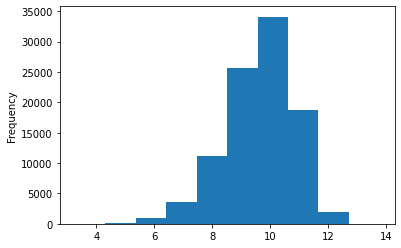

In [0]:
twitter_df_preprocess['c_statuses_count_log'].plot(kind='hist')

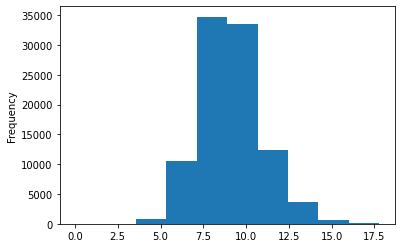

In [0]:
twitter_df_preprocess['c_followers_count_log'].plot(kind='hist')

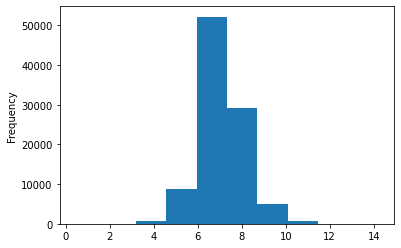

In [0]:
twitter_df_preprocess['c_followees_count_log'].plot(kind='hist')

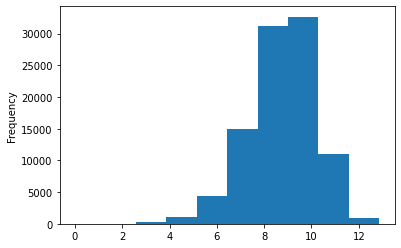

In [0]:
twitter_df_preprocess['c_favorites_count_log'].plot(kind='hist')

In [0]:
# update the preprocessed features
feature_activity = ['c_statuses_count_log', 'c_followers_count_log', 'c_followees_count_log', 'c_favorites_count_log', 'c_listed_count', 'is_50', 'is_50_2', 'is_63','is_63_2']
features = feature_activity + feature_network + feature_content

var = features + ['hate']
twitter_df = twitter_df_preprocess.copy() # copy an original dataframe for cleaned dataframe
twitter_df = twitter_df[var]
twitter_df.head()

### 2.3.3. Dataset Split
Focusing our target variable, `hate`, we need to split the original dataset into the dataframe for the annotated/unannotated users.

In [0]:
annotated_df = twitter_df[~twitter_df['hate'].astype(str).str.contains('other')]
annotated_df.shape

(4875, 518)

In [0]:
# convert target variable into a binary variable
annotated_df['hate'] = annotated_df['hate'].apply(lambda x: 1 if x=='hateful' else 0)
annotated_df['hate']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


user_id
0         0
22        0
29        0
44        0
85        0
         ..
100312    0
100338    0
100362    0
100380    1
100385    0
Name: hate, Length: 4875, dtype: int64

In [0]:
unannotated_df = twitter_df[twitter_df['hate'].astype(str).str.contains('other')]
unannotated_df.shape

(91474, 518)

# 3. Exploratory Data Analysis
Before model building, we will explore the annotated dataset for more general insights.

## 3.1. Distribution Analysis
Then, let's compare the distribution of some variables between the hateful users and the normal users. Such comparision can help us identify the differences between these two types of users 

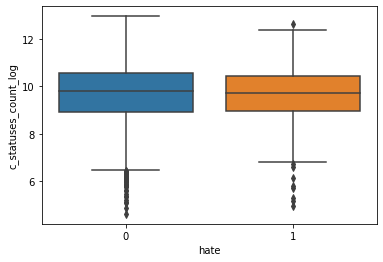

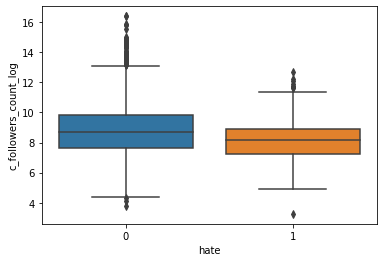

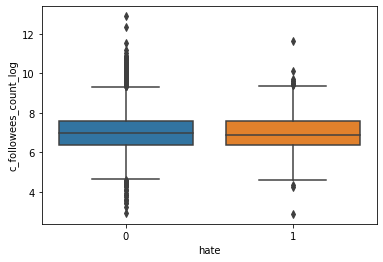

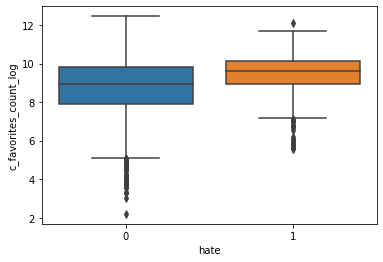

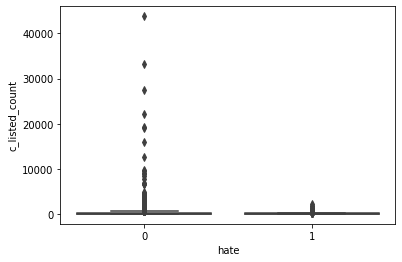

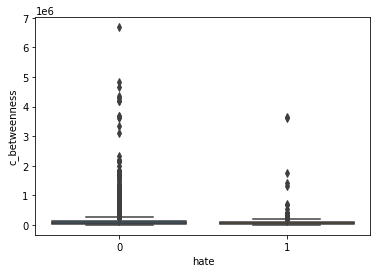

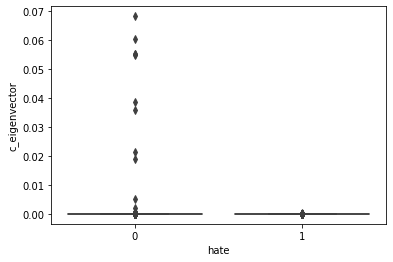

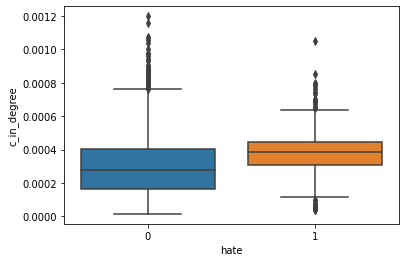

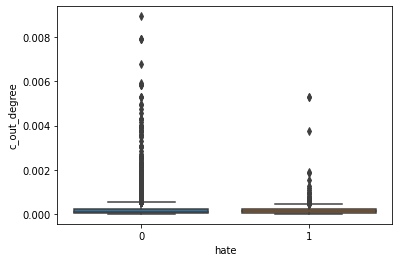

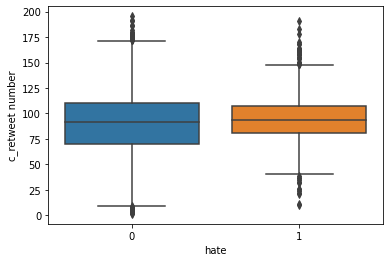

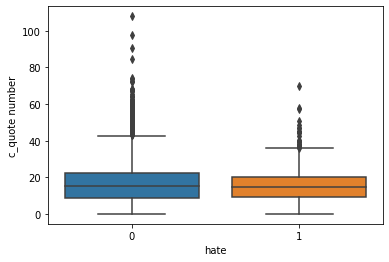

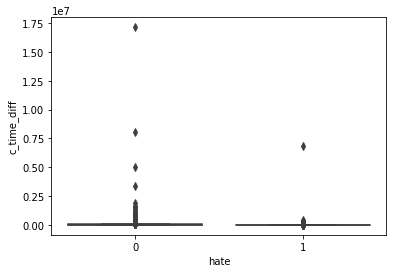

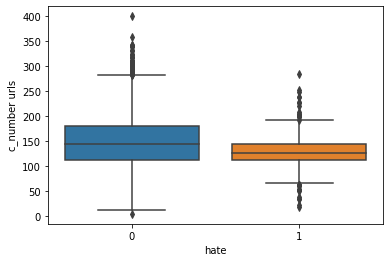

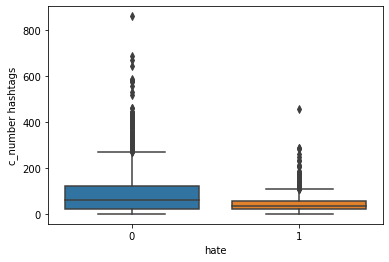

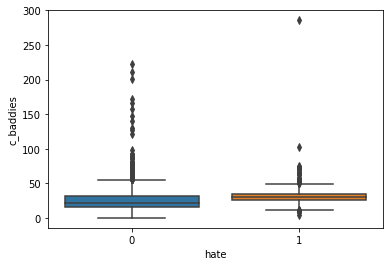

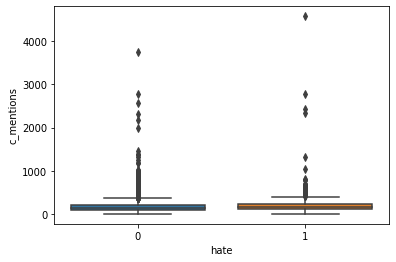

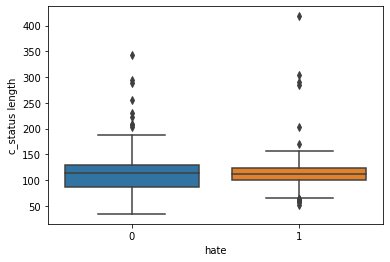

In [0]:
# based on previous review, select the numeric continuous variables for distribution analysis
feature_numeric = ['c_statuses_count_log', 'c_followers_count_log', 'c_followees_count_log', 'c_favorites_count_log', 'c_listed_count',
          'c_betweenness', 'c_eigenvector', 'c_in_degree', 'c_out_degree','c_retweet number','c_quote number',
          'c_time_diff','c_number urls','c_number hashtags','c_baddies','c_mentions','c_status length']
for var in feature_numeric:
  sns.boxplot(y=var, x="hate", data=annotated_df)
  plt.show()

For most of the numeric features, the distribution is identical, but still we can find out that there are distribution differeces in the variables of `followers_count`, `favourites_count`,`in_degree`, `retweet_number`,`number_urls`, `number_hashtags`, `mentions`, `baddies`. 
More specific, the hateful users have less followers and less hashtags, and more in-degree network. Their number of favourites, retweet, and url number, bad words and the length of a post are in smaller variance.

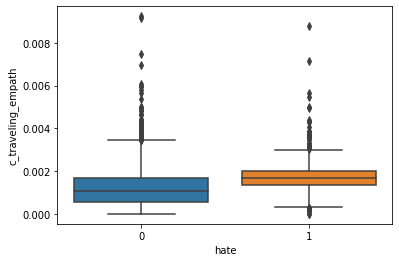

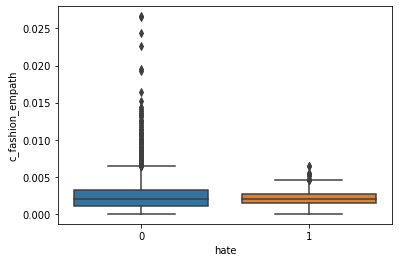

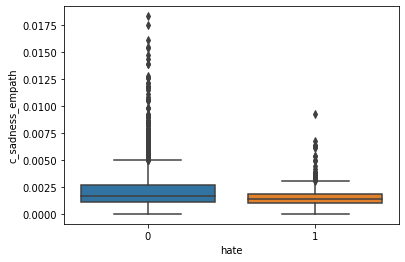

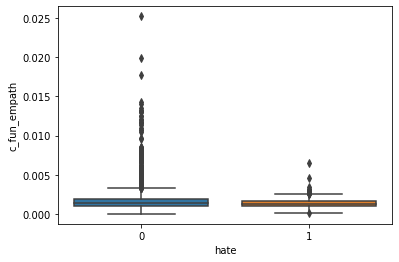

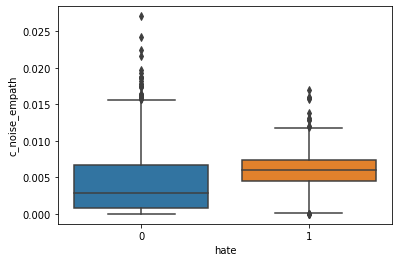

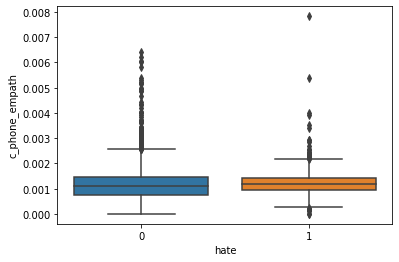

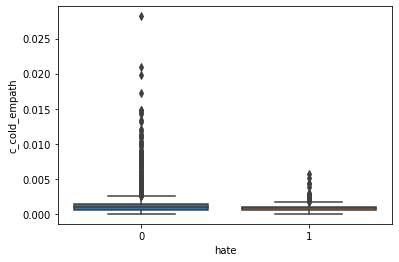

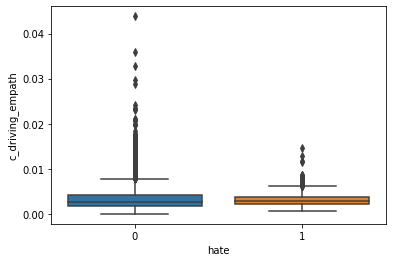

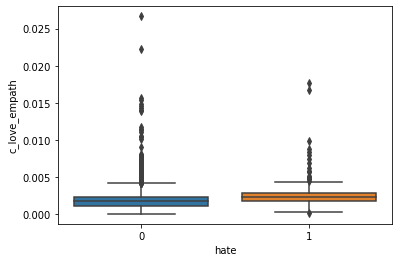

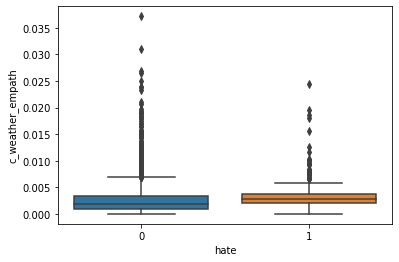

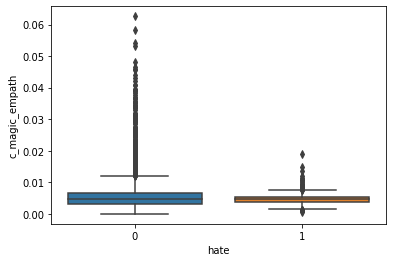

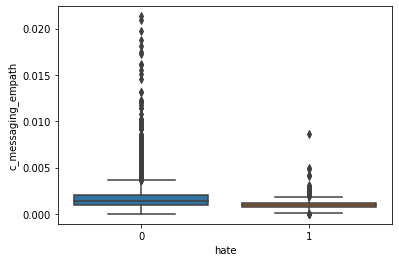

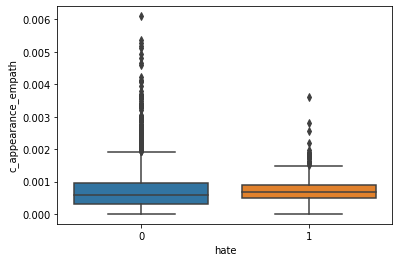

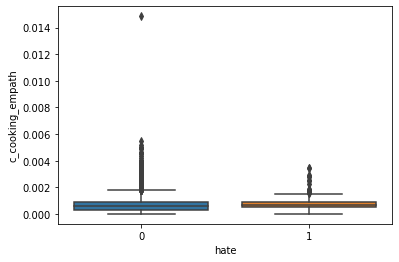

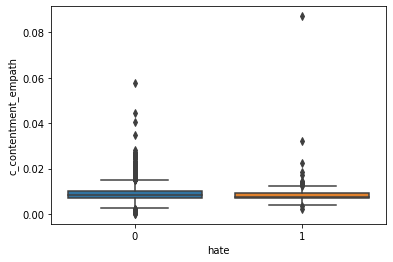

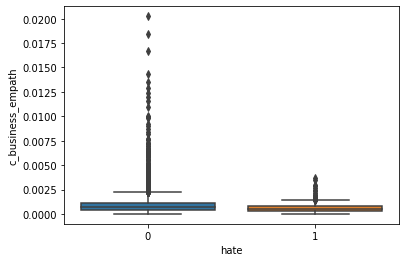

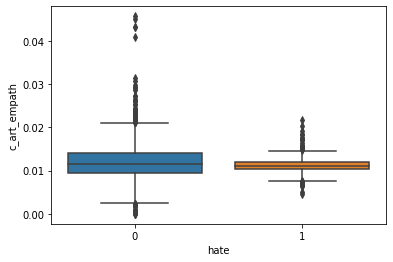

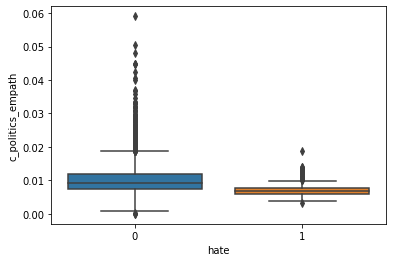

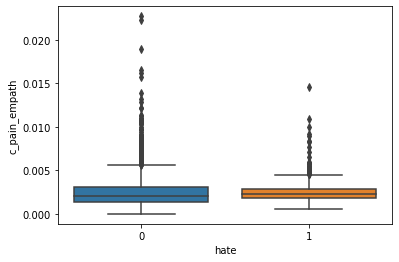

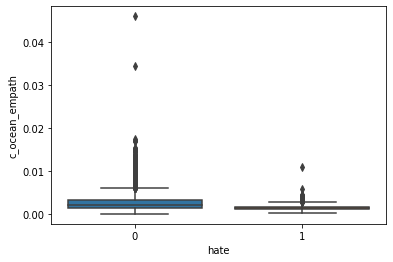

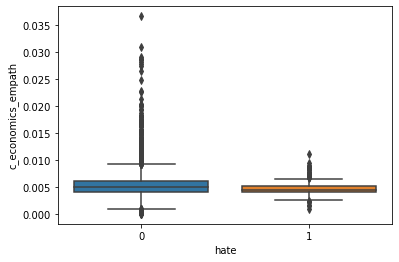

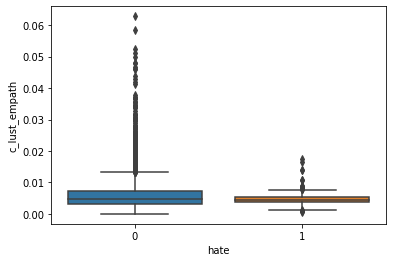

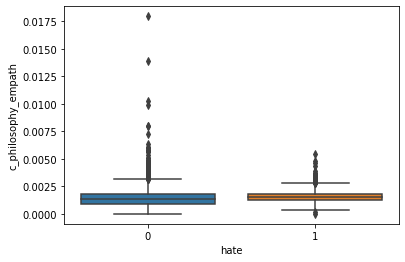

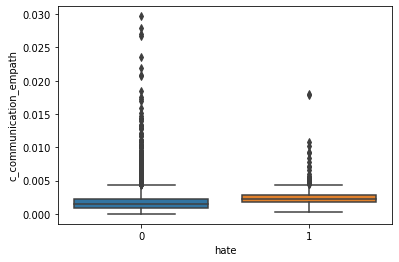

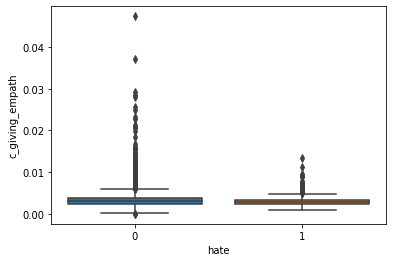

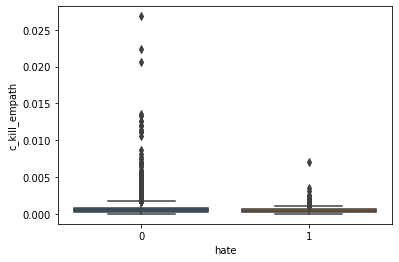

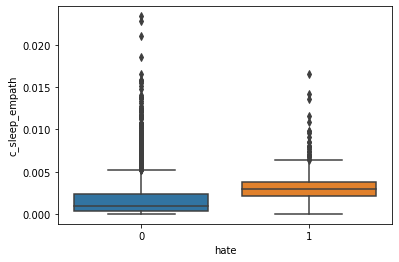

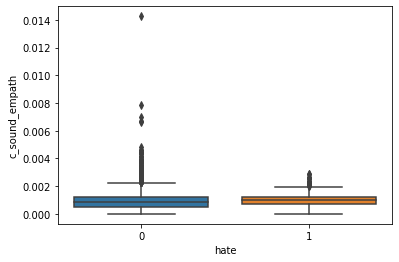

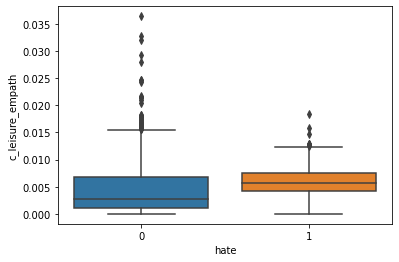

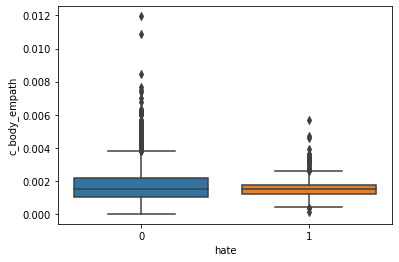

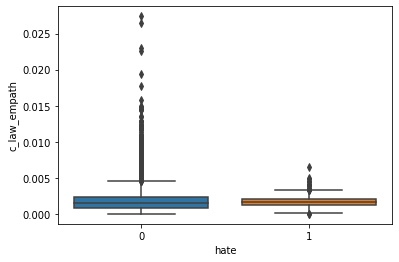

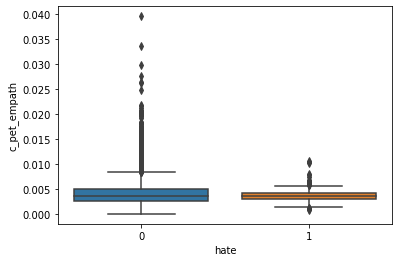

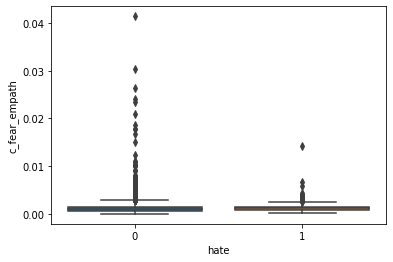

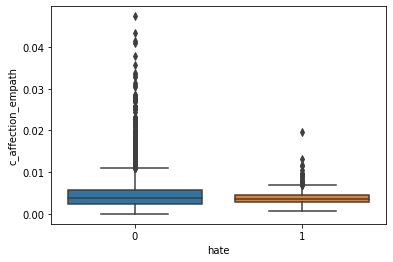

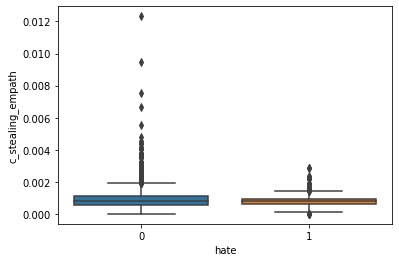

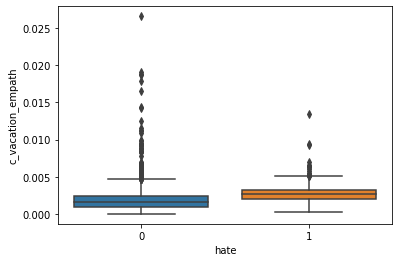

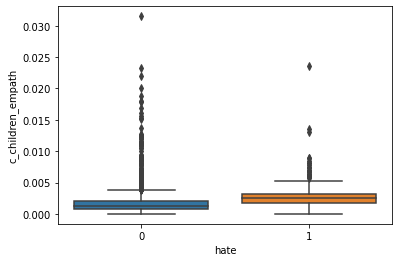

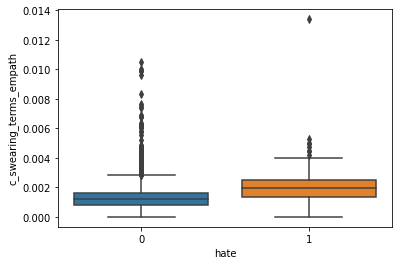

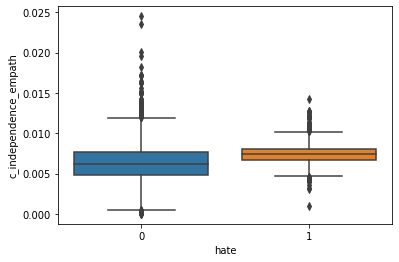

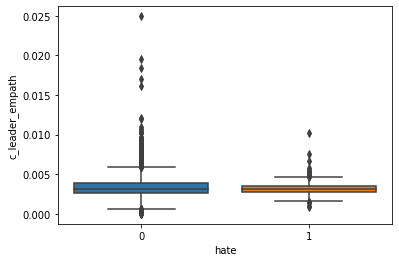

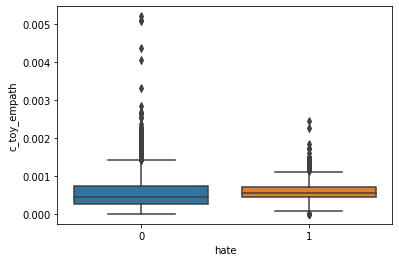

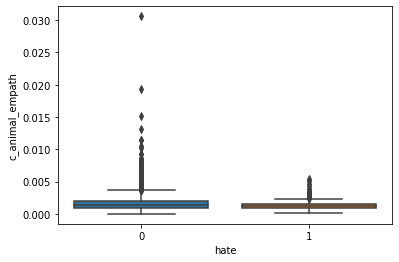

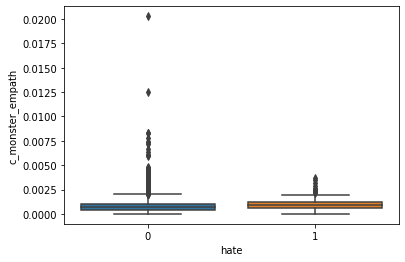

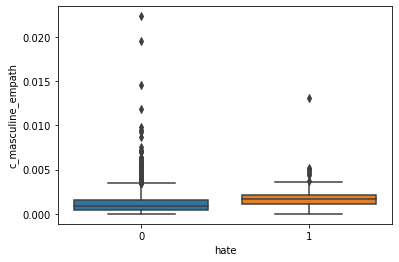

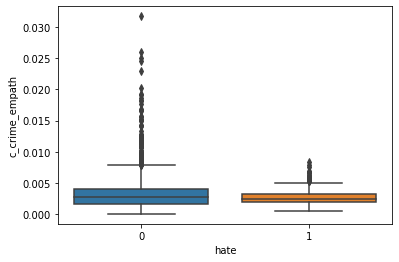

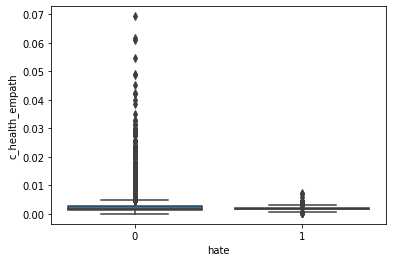

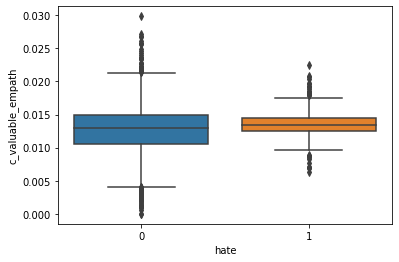

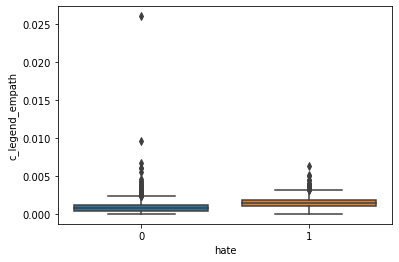

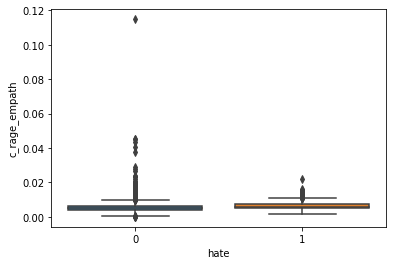

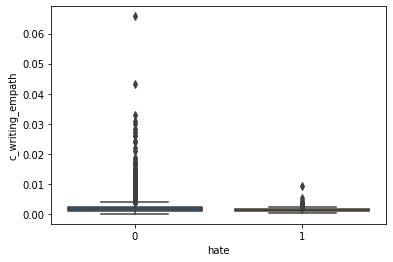

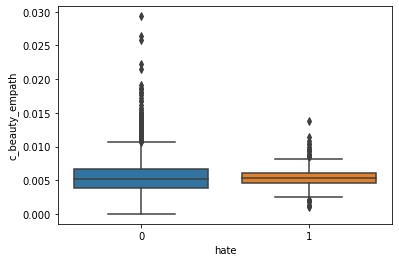

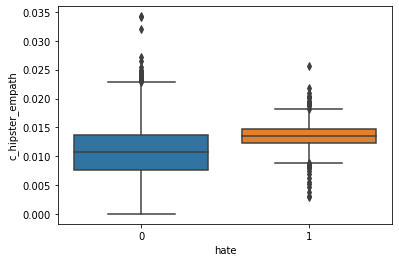

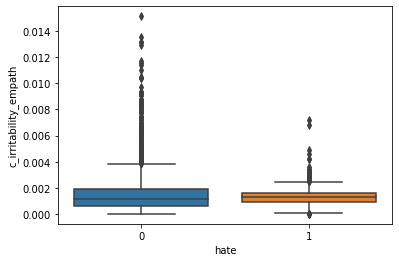

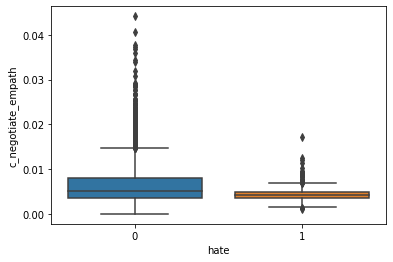

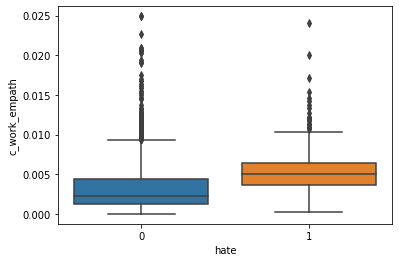

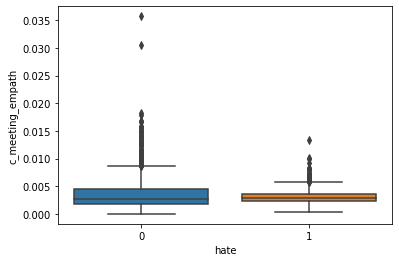

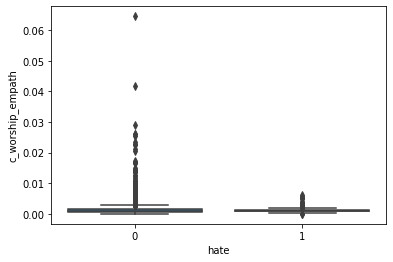

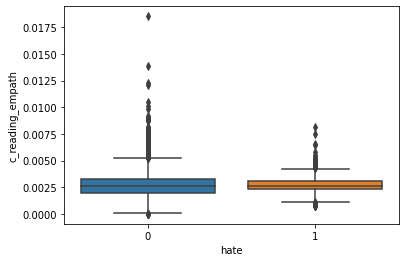

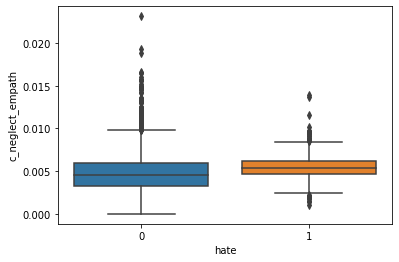

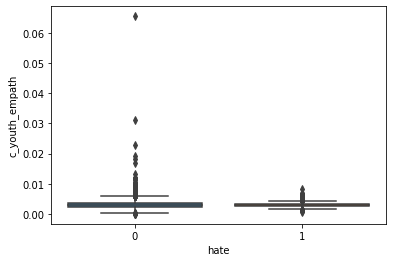

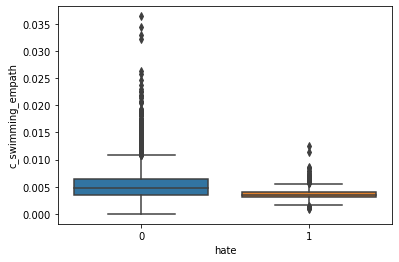

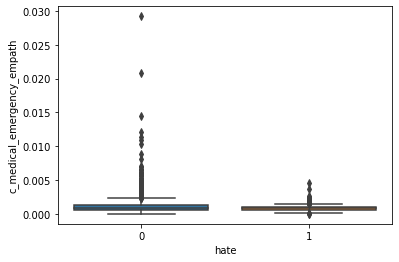

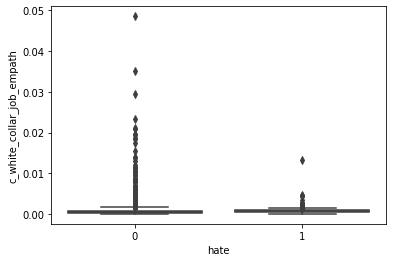

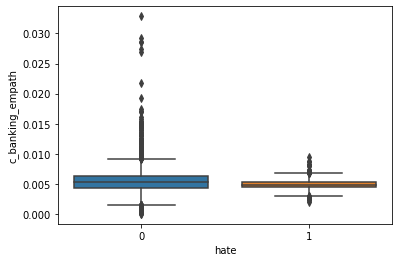

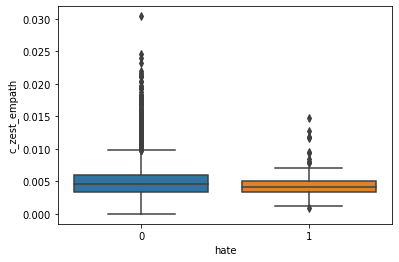

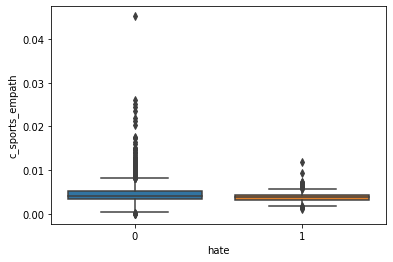

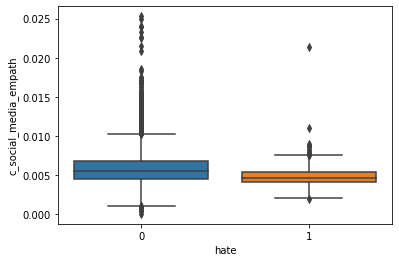

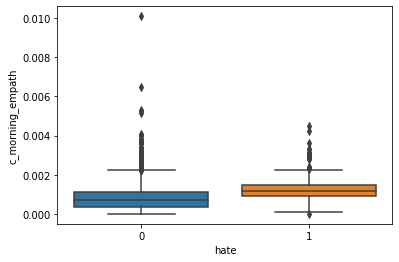

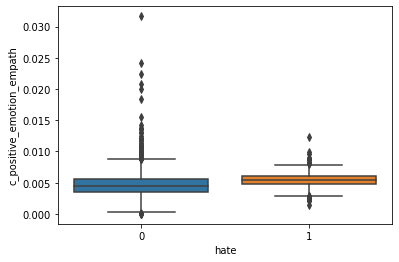

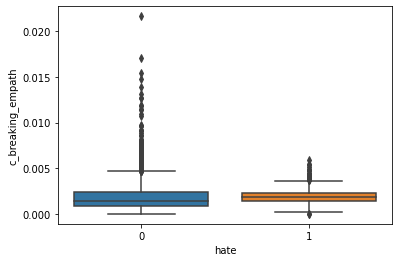

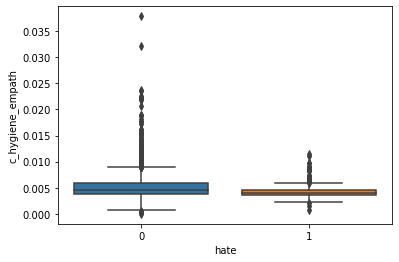

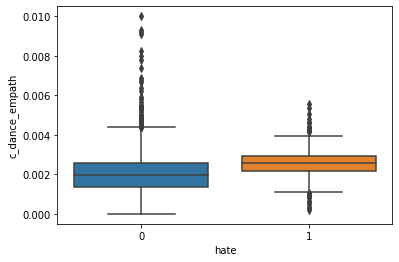

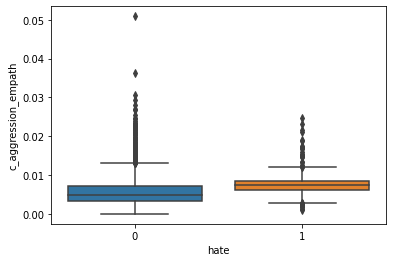

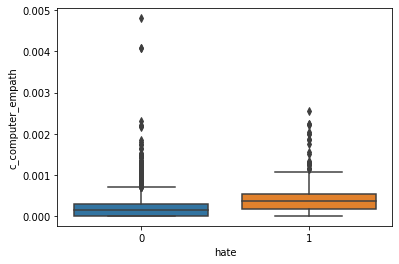

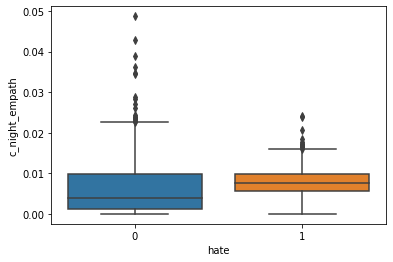

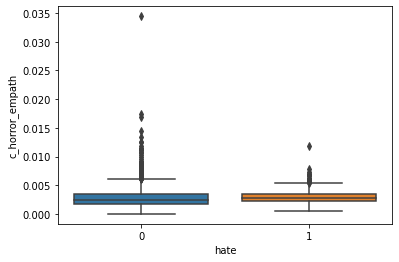

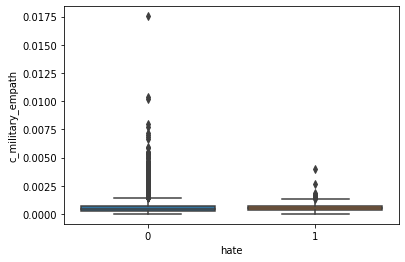

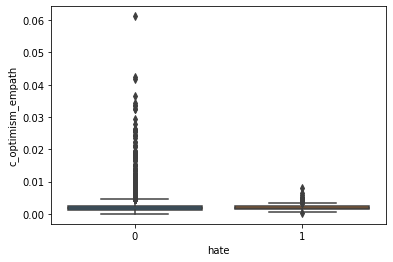

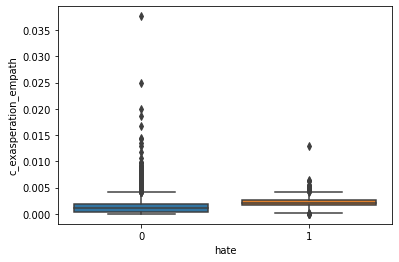

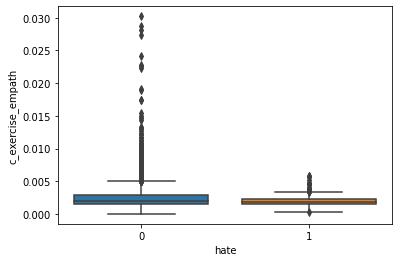

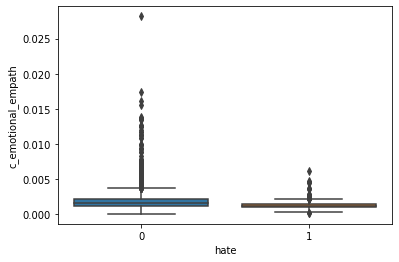

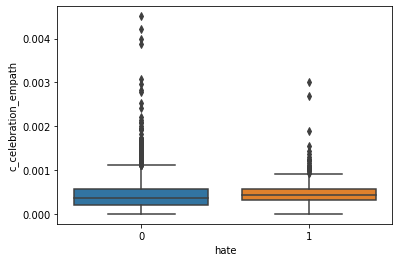

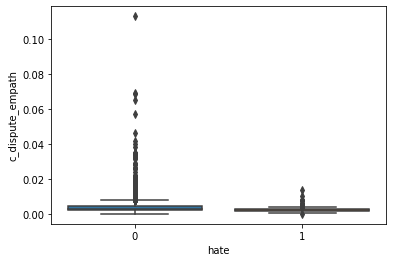

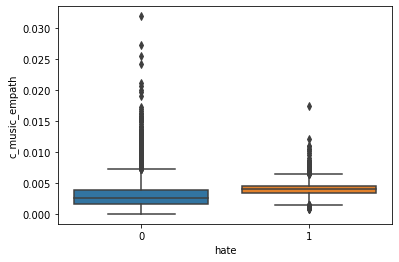

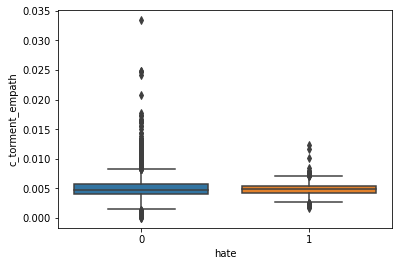

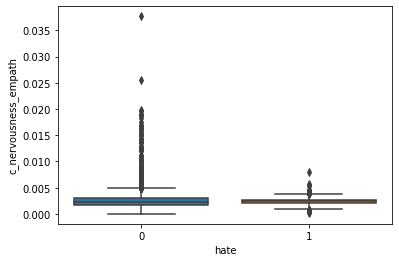

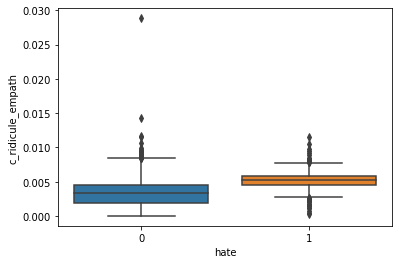

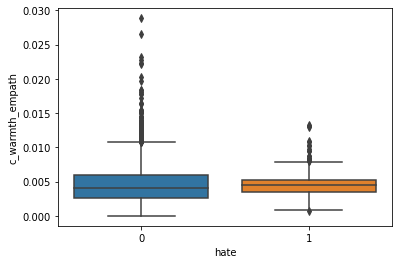

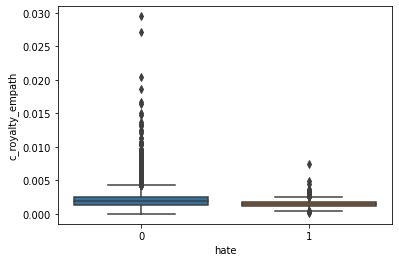

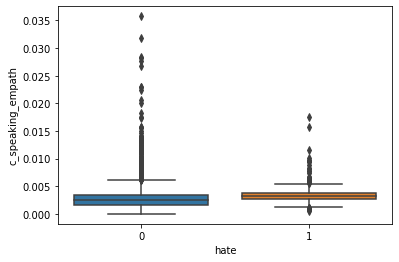

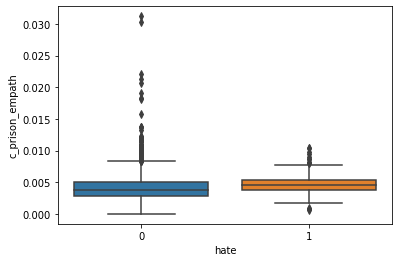

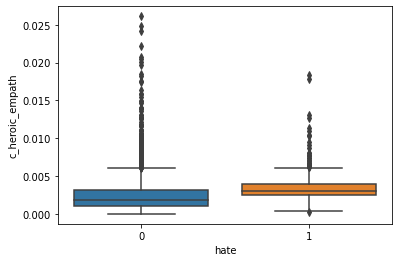

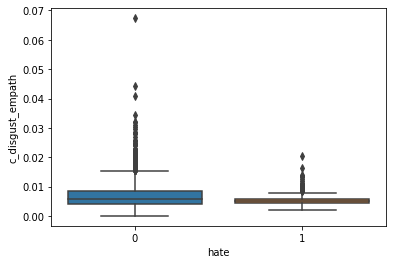

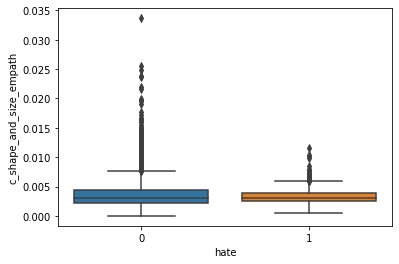

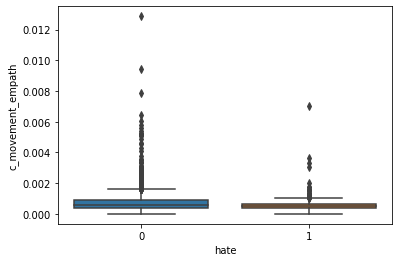

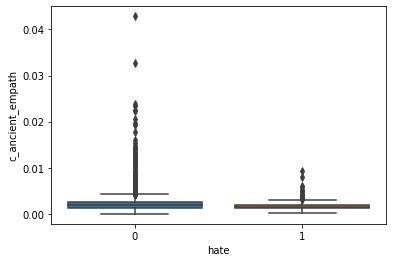

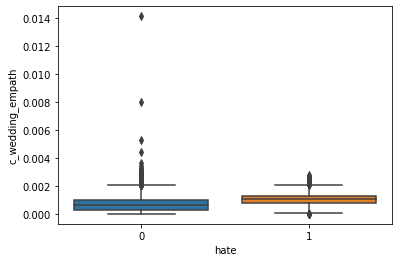

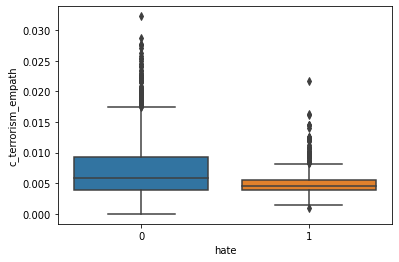

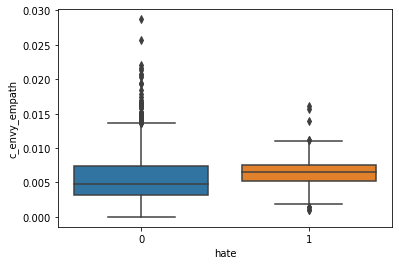

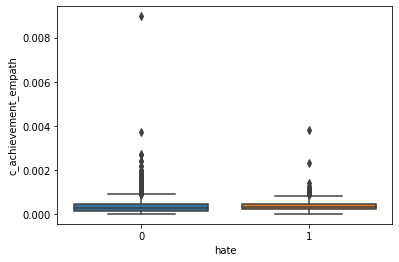

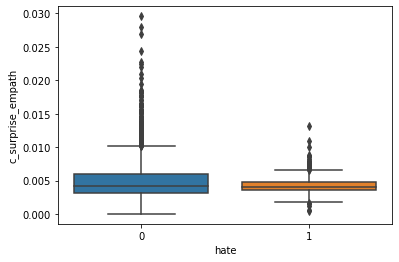

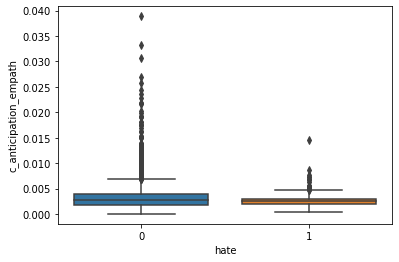

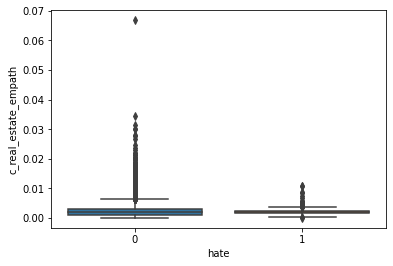

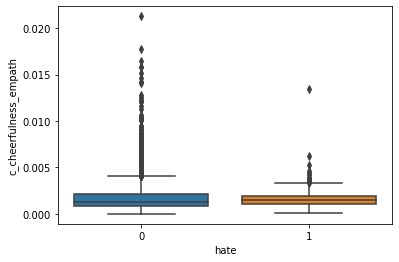

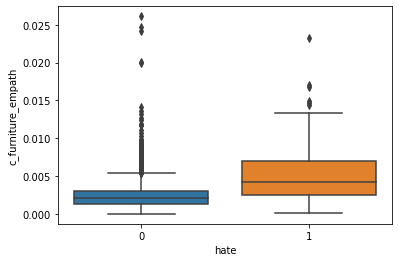

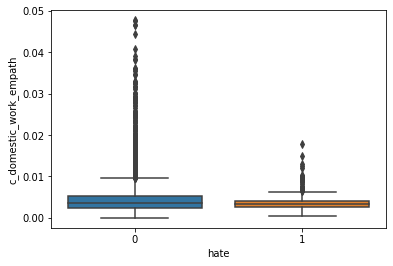

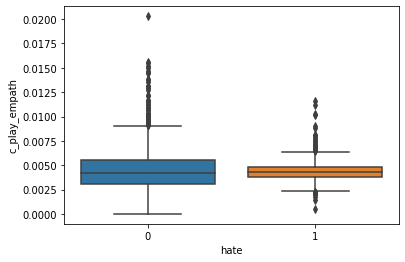

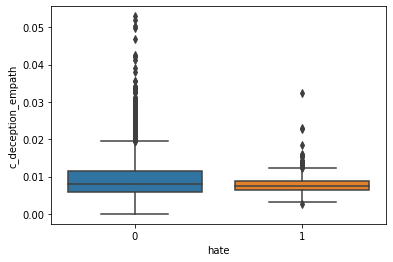

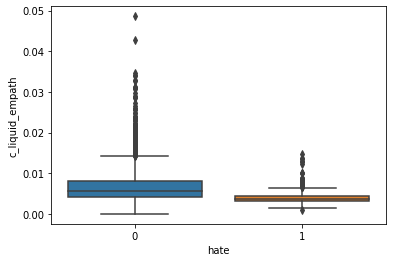

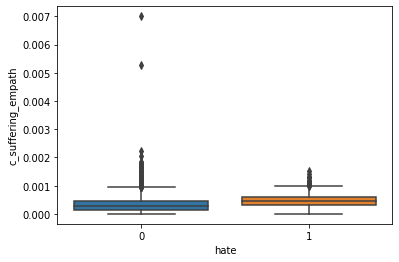

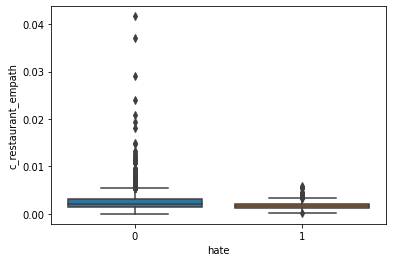

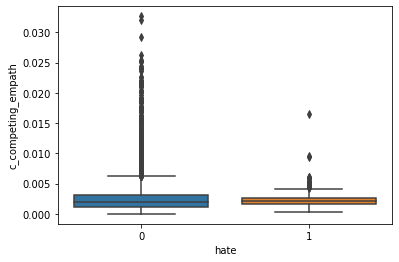

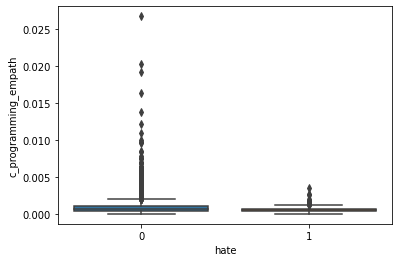

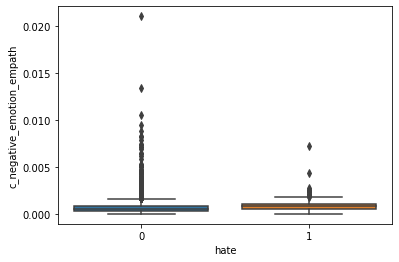

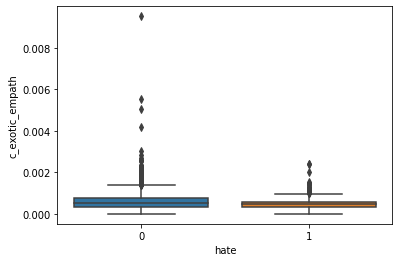

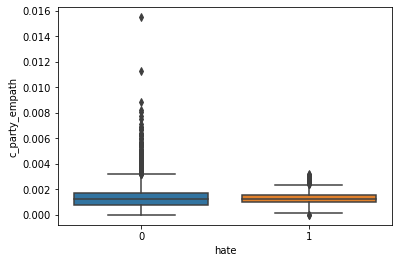

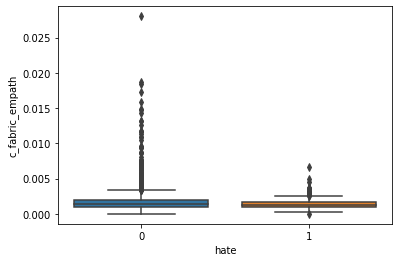

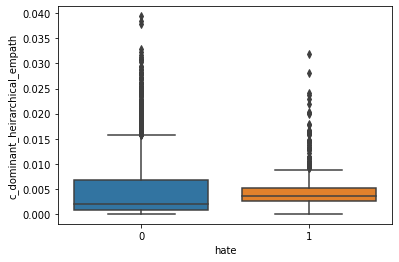

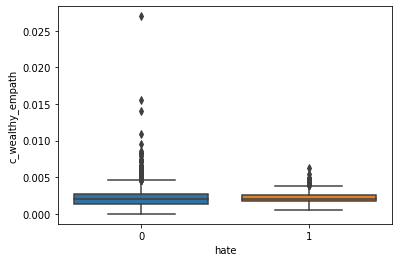

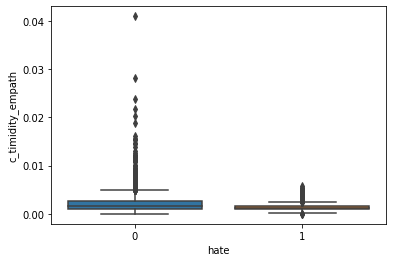

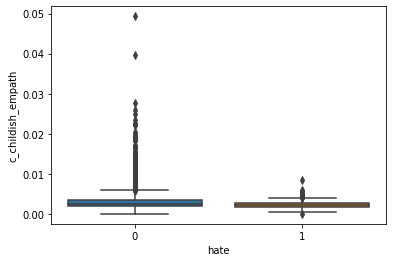

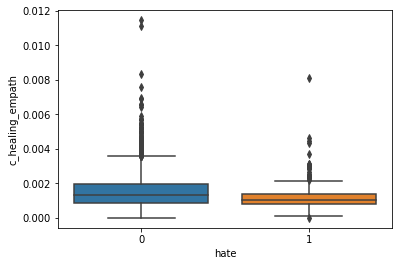

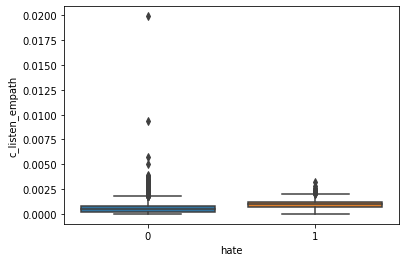

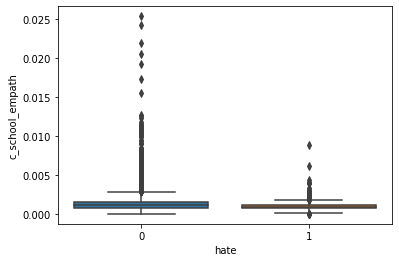

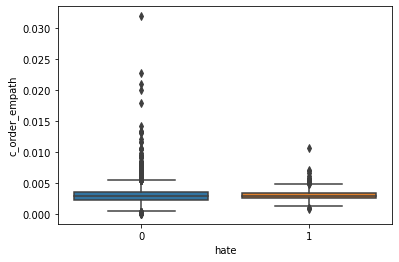

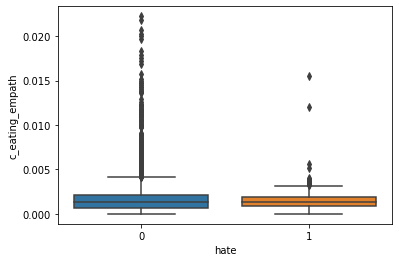

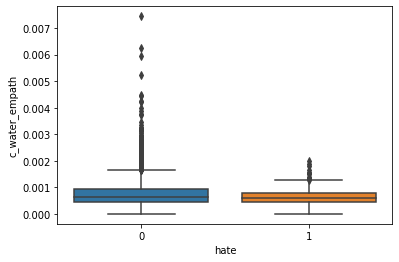

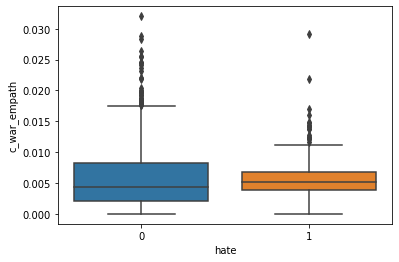

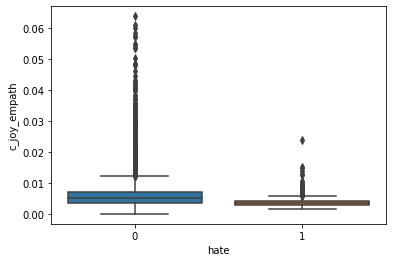

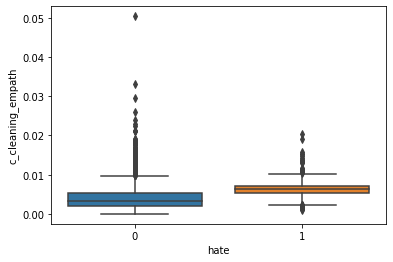

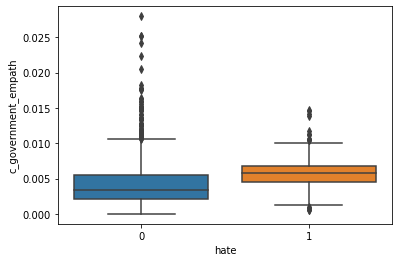

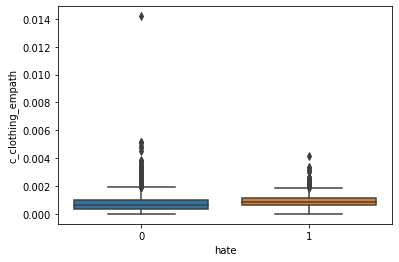

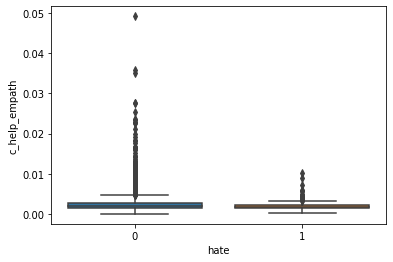

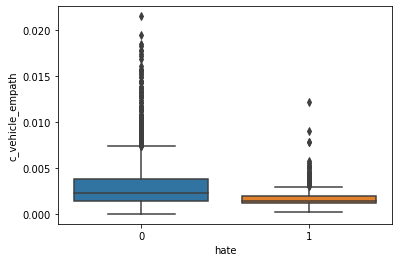

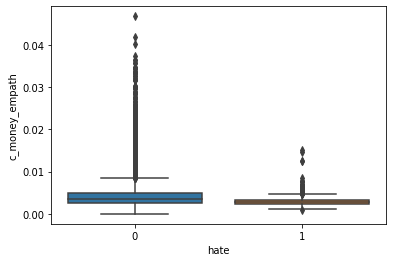

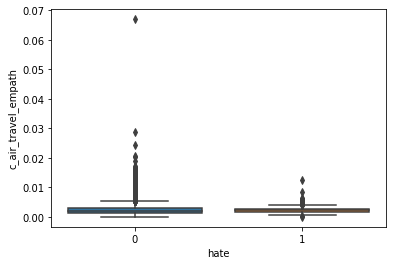

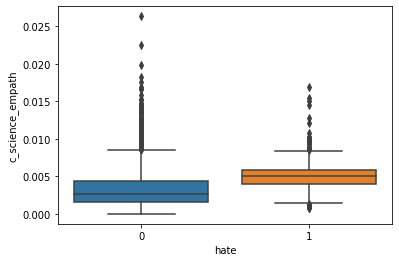

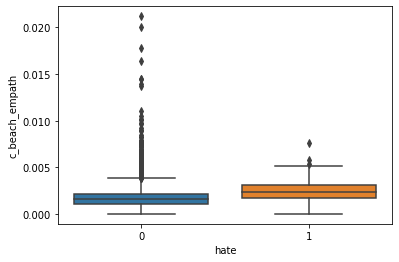

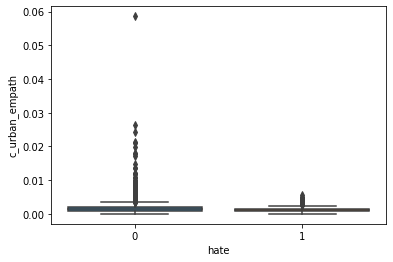

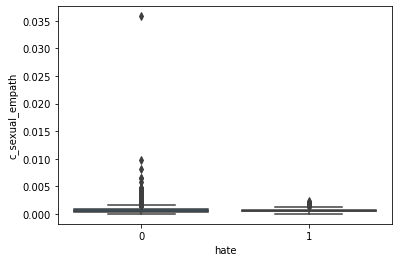

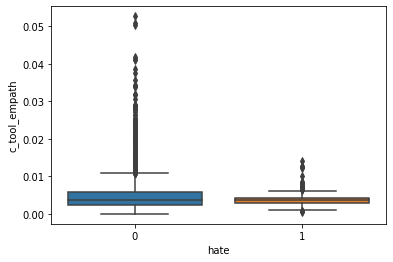

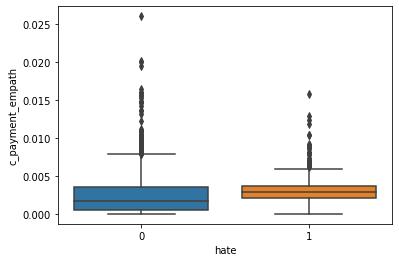

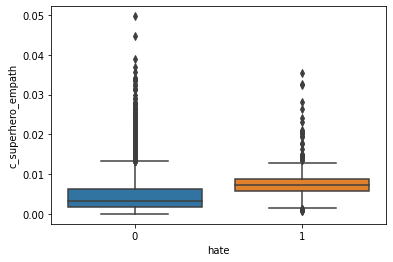

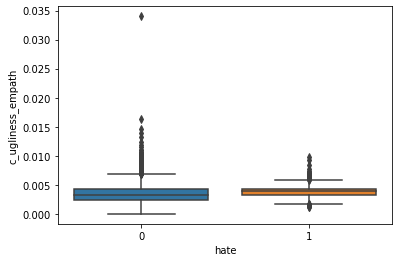

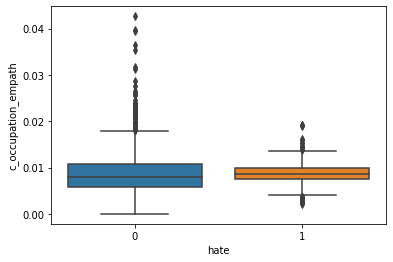

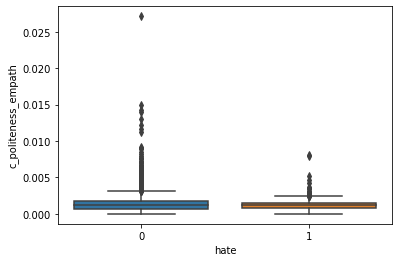

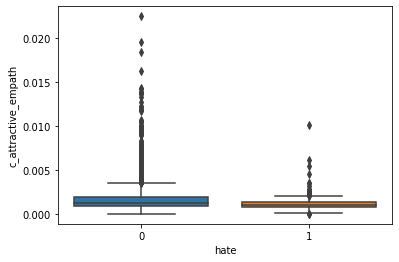

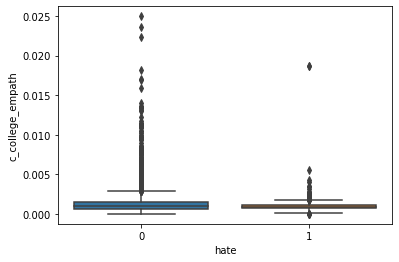

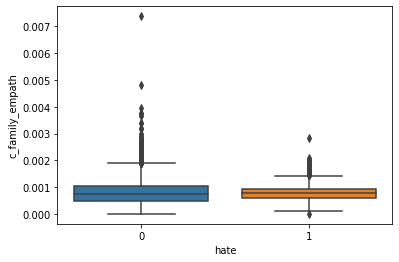

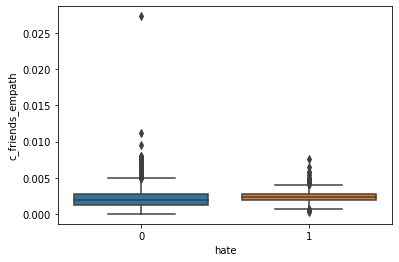

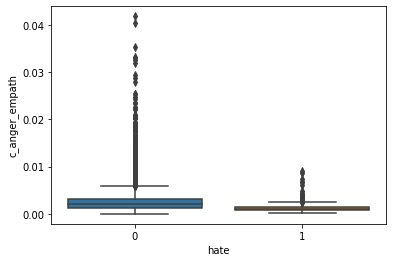

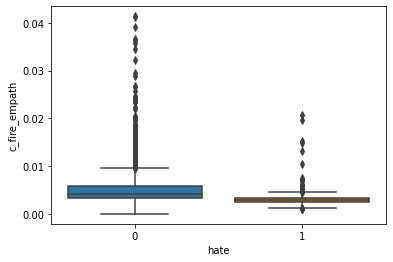

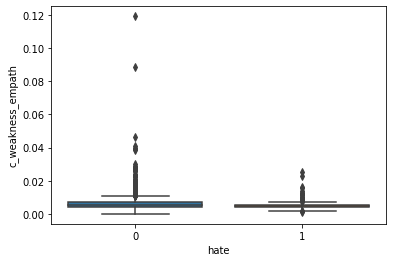

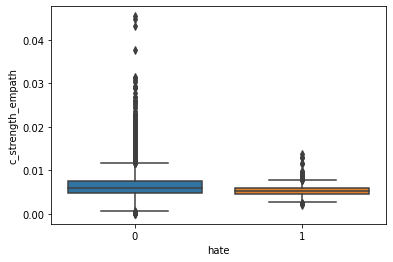

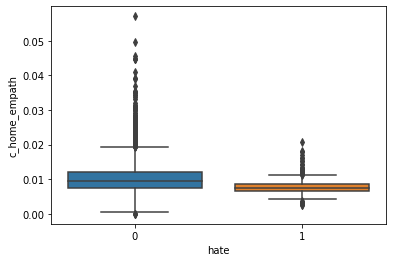

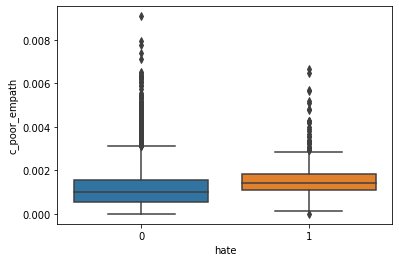

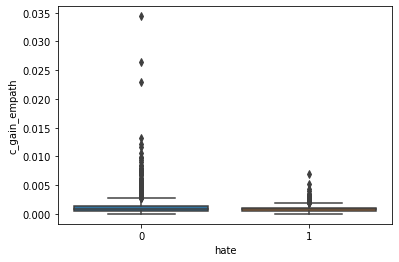

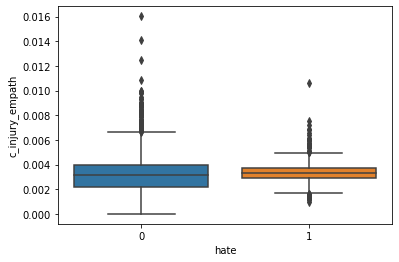

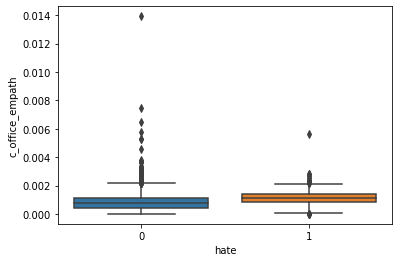

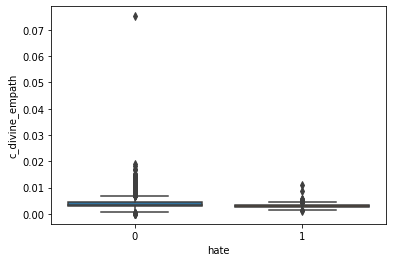

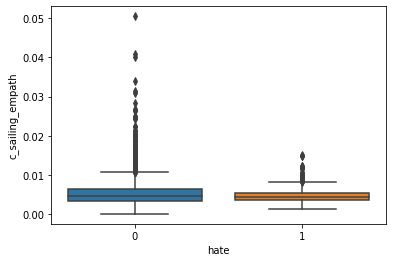

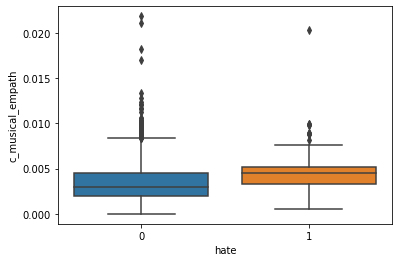

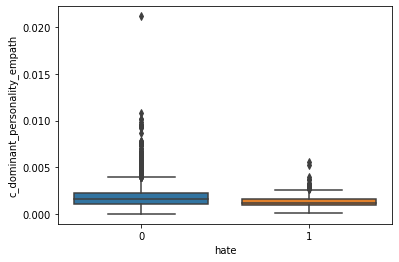

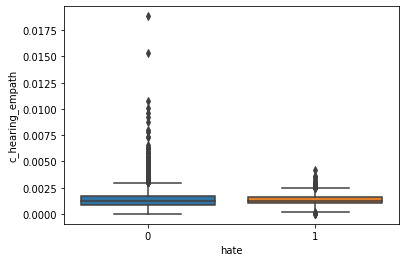

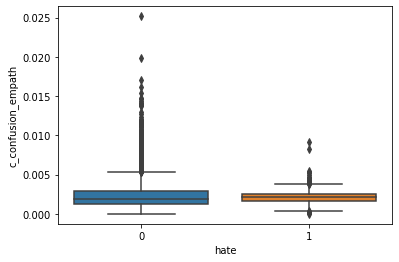

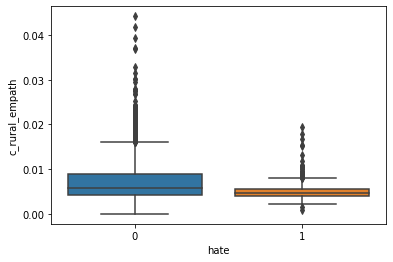

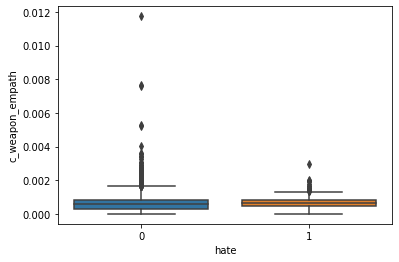

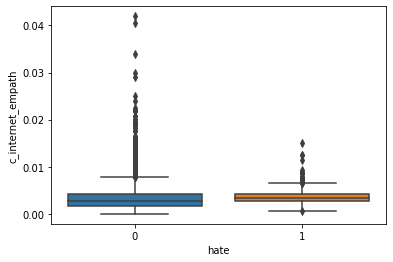

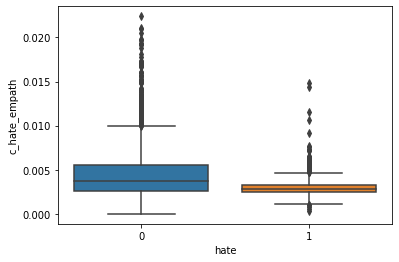

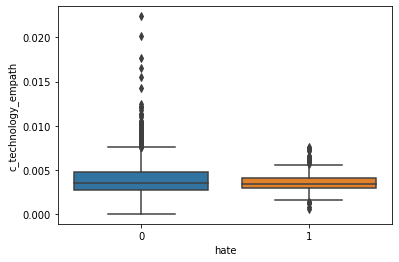

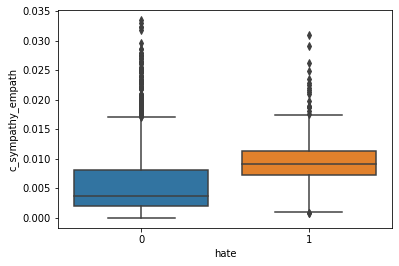

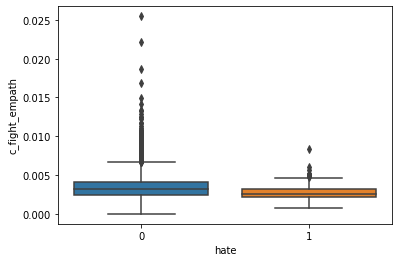

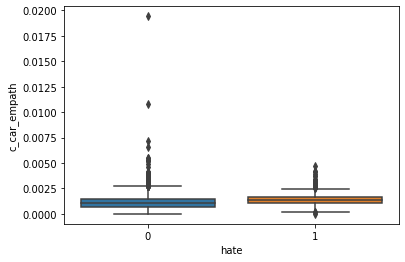

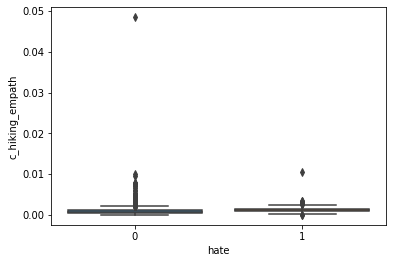

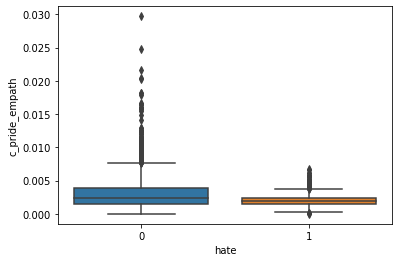

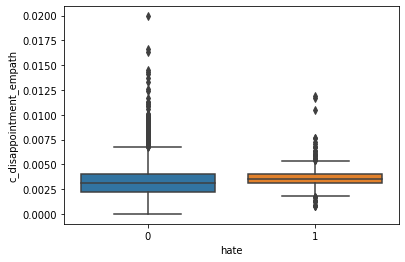

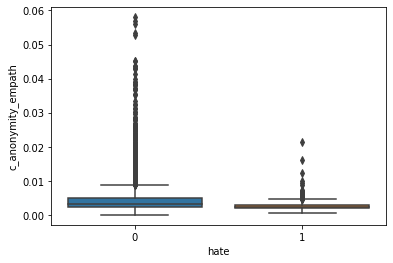

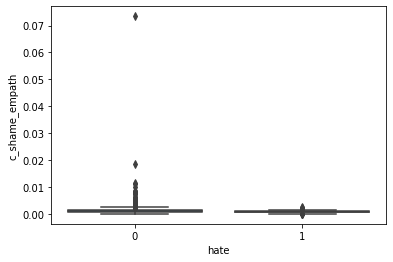

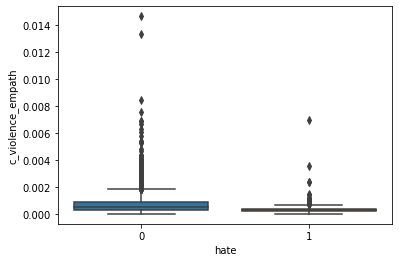

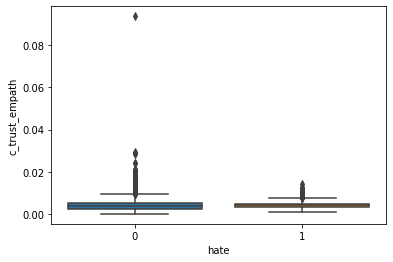

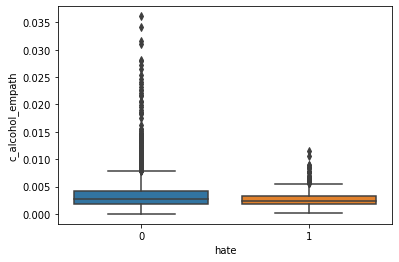

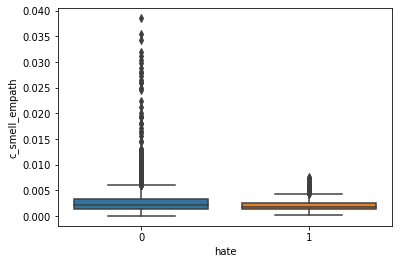

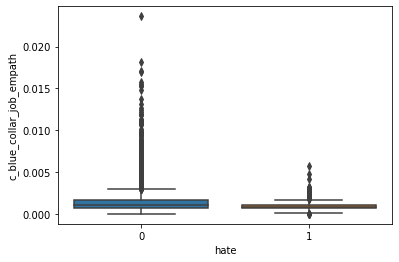

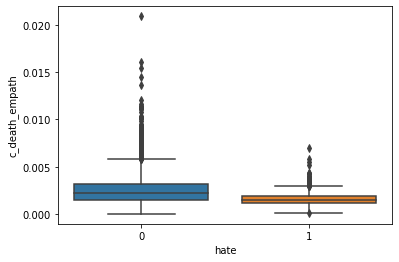

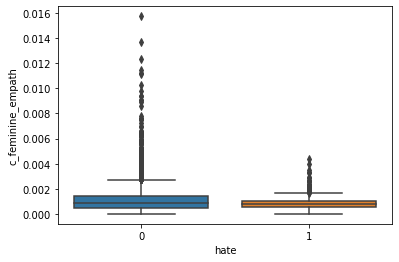

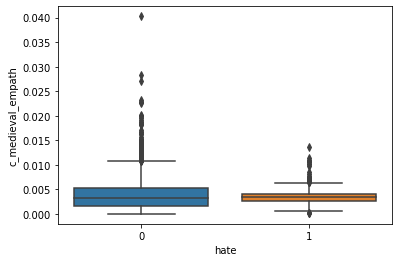

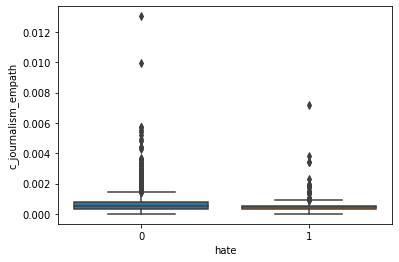

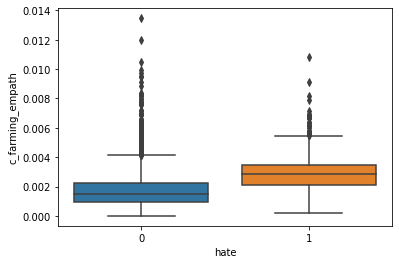

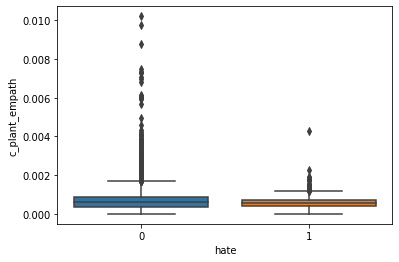

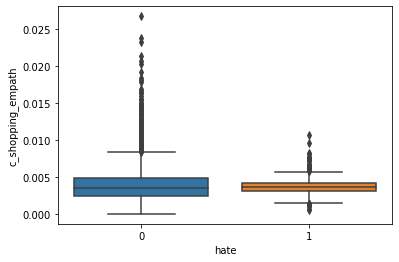

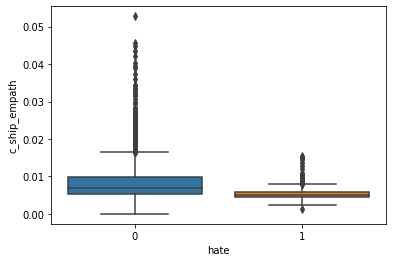

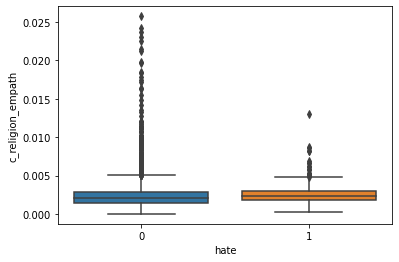

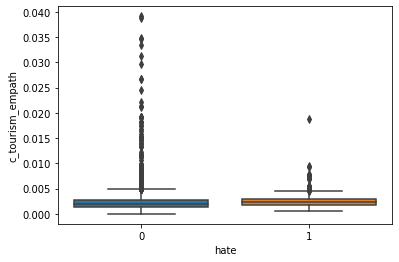

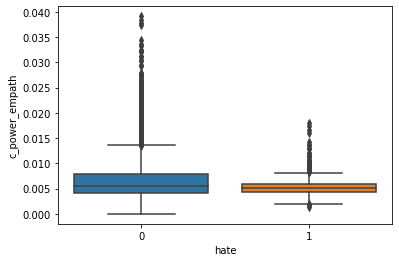

In [0]:
# select the empathy variables for distribution analysis
for var in feature_empath:
  sns.boxplot(y=var, x="hate", data=annotated_df)
  plt.show()

While reviewing some of these features, I can identify some differences of distribution between the normal users and hateful users. 
More specific, among the hatful users, there are:
1. more posts mentioning: 
Travelling, noise, love, communication, sleep, sound, leisure, vacation, children, term, independence, monster, masculine, legend, hipster, work
2. less posts mentioning:
Sadness, politics, economics, negotiation
3. smaller variance: 
Magic, messaging, art, ocean, lust, valuable.

For most of these empathy words, they are neutural, like a statement. However, it's interesting to find out there there are more posts mentioning love for the hateful users.


## 3.2. Correlation Analysis
Besides distribution analysis, the correlation analysis can also offer us more insights into the differences between the hatful users and normal users.

In [0]:
# define a function to visualize correlation
def corr_plot(df):
  corr_df = df.corr().abs()
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(corr_df.loc[list(corr_df.index),list(corr_df.index)], square=False, annot=True, fmt='.2g')
  ax.set_title('Correlation Matrix in Absolute Values')

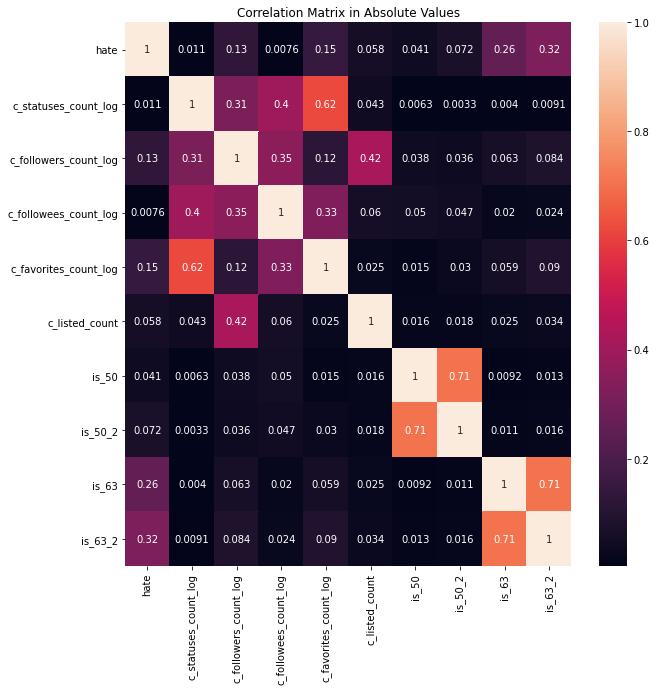

In [0]:
# show the correlation among the variables concerning user activity
feature_activity_hate = ['hate'] + feature_activity 
corr_plot(annotated_df[feature_activity_hate])

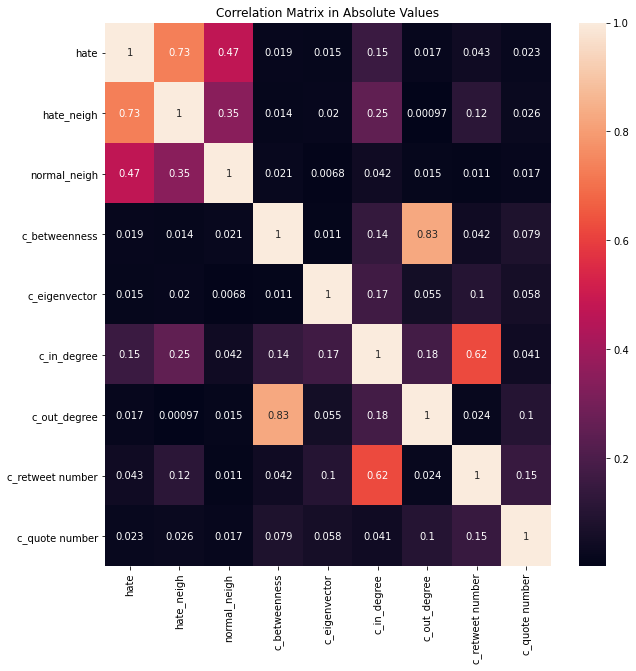

In [0]:
# show the correlation among the variables concerning user network
feature_network_hate = ['hate'] + feature_network 
corr_plot(annotated_df[feature_network_hate])

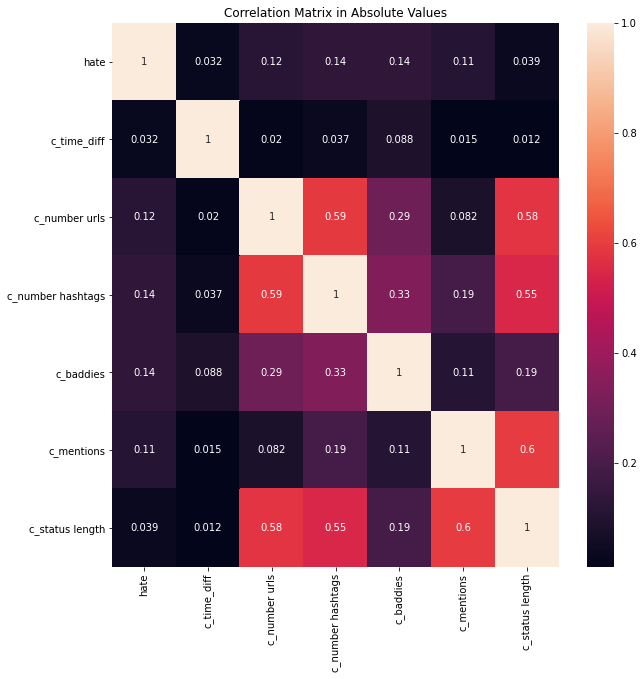

In [0]:
# show the correlation among the variables concerning the tweets
feature_tweet_hate = ['hate'] + feature_tweet 
corr_plot(annotated_df[feature_tweet_hate])

While comparing the correlation between hateful label and the variables of three types, we can find out that the label are more related to the network features. More specific, from the linear relationship perspective, the user label is most related to the binary variable of whehter he/she is in the network of hateful user.

Then, let's see the correlation within the features. It's reasonable that the variable of user activity are relatively more related to each other, like the users of higher number of followers are likely to have more followees. Also, the users' suspend and deletion status are of high correlation. It also make sense that the users with more retweet are likely to be the hateful users, because the hateful speech are more likely to be spread through retweet and further discussion. When it comes to the numeric features concerning the content, it's also reasonable that the number of url, hashtags, mentions and the length of the tweets are highly correlated, since if more url/ hashtags/ mentions are included in a post, the post is likely to be longer.

Then, let's more focus on the correlation with the target variable.

In [0]:
# define a function to visulize the correlation 
# with target varaible, the label whether a user is hateful/normal
def corr_hate_plot(df):
  corr_df = df.corr()
  corr_hate = corr_df.loc[corr_df['hate']!=1, 'hate']
  corr_hate = corr_hate.sort_values(ascending = False)
  num = df.shape[1] # record the varaiable number for size of the correlation plot
  plt.figure(figsize=(1/2*num,1/2*num))
  sns.set(style="whitegrid")
  ax = sns.barplot(y=corr_hate.index,x=corr_hate.astype(np.float))
  y = 0
  for index, value in corr_hate.iteritems():
      ax.text(0, y, round(float(value),4), color='black',va='center')
      y+=1
  # ax.set_xlim(-0.25,0.25)
  plt.xticks(rotation=90)
  plt.grid(False)

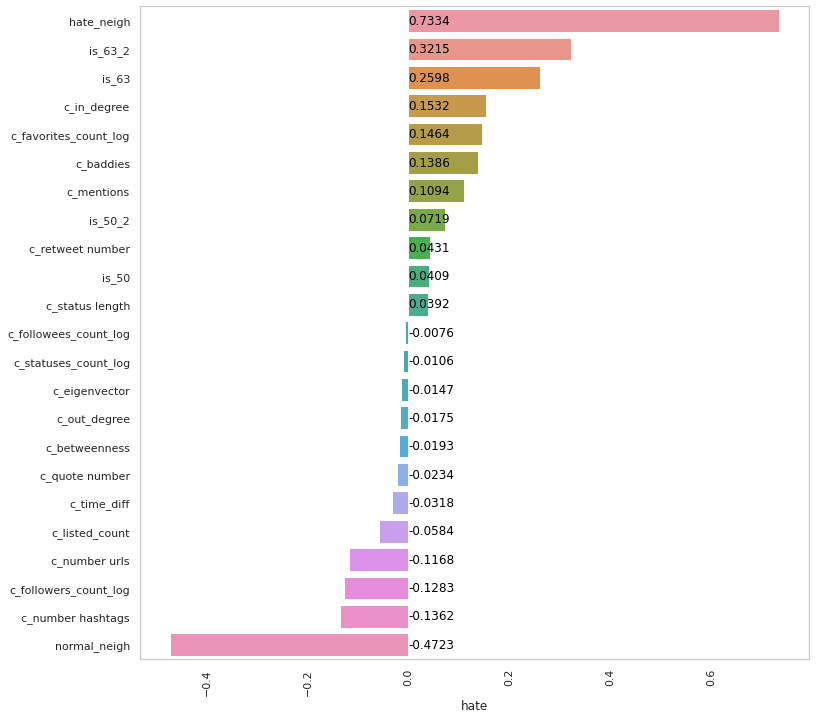

In [0]:
# focus on the correlation between the hateful/normal labels and the numeric features
feature_numeric_hate = ['hate'] + feature_activity + feature_network +feature_tweet 
corr_hate_plot(annotated_df[feature_numeric_hate])

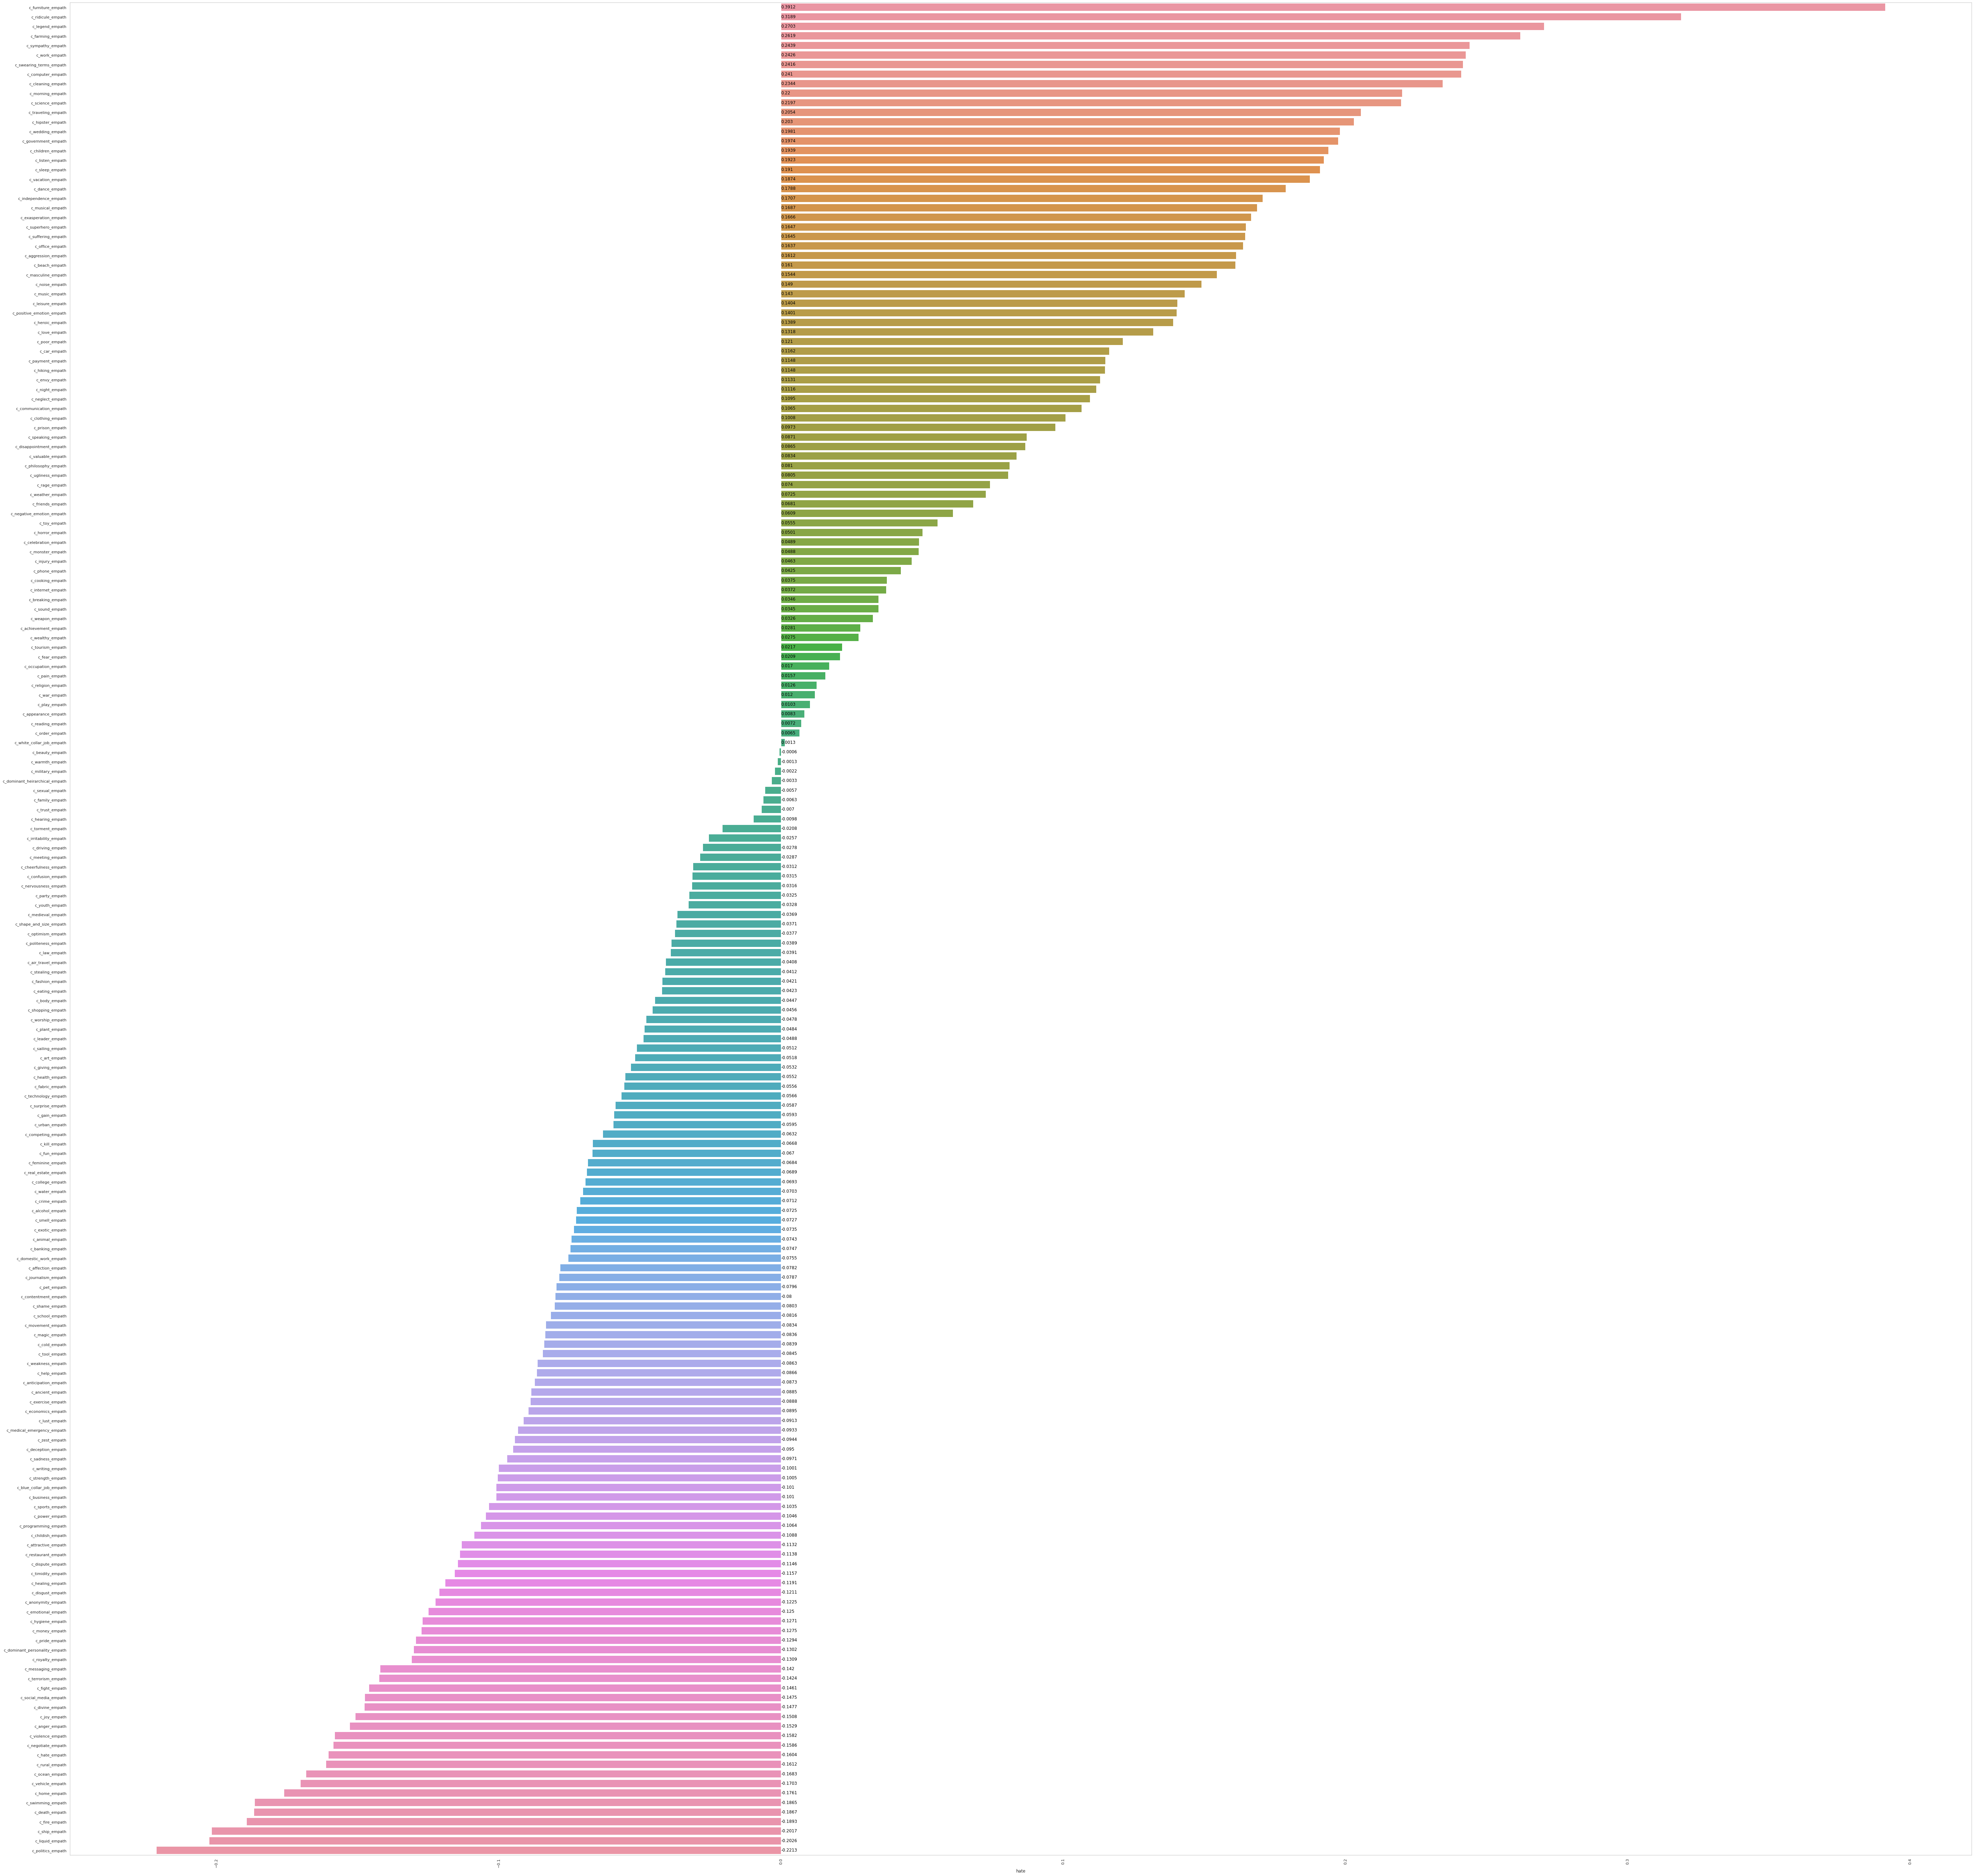

In [0]:
# focus on the correlation between the hateful/normal labels and the empathy features
feature_empath_hate = ['hate'] + feature_empath  
corr_hate_plot(annotated_df[feature_empath_hate])

The correlations over with different `*_empath` varies. Let's dig into the ones which are most correlated to `hate`

In [0]:
# focus on the correlation between the hateful/normal labels and the glove vectors
feature_glove_hate = ['hate'] + feature_glove  
corr_hate_plot(annotated_df[feature_glove_hate])

The correlation among different glove vectors varies as well, indicating that content of the posts is 

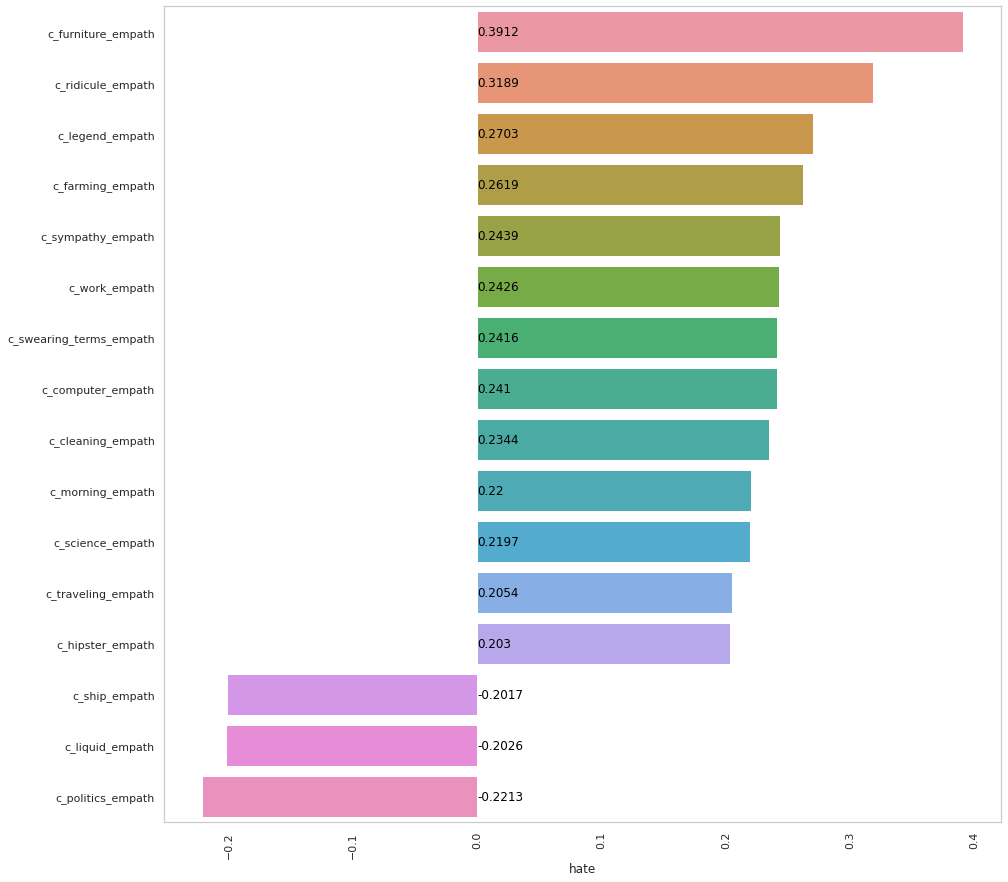

In [0]:
# visulize the most correlated empathy features

corr_empath_df = annotated_df[feature_empath_hate].corr()
corr_empath_hate = corr_empath_df.loc[(corr_empath_df['hate']!=1) & ((corr_empath_df['hate']>0.15) | (corr_empath_df['hate']<-0.15)), 'hate']
corr_empath_hate = corr_empath_hate.sort_values(ascending = False)
plt.figure(figsize=(15,15))
sns.set(style="whitegrid")
ax = sns.barplot(y=corr_empath_hate.index,x=corr_empath_hate.astype(np.float))
y = 0
for index, value in corr_empath_hate.iteritems():
    ax.text(0, y, round(float(value),4), color='black',va='center')
    y+=1

plt.xticks(rotation=90)
plt.grid(False)

Then, we can find out that these 15 variables are more correlated with the user labels. It makes sense that the variable concerning ridiculous is more positively related. However, it's strange that some more neutral variables are highly correlated to the label, like the labels for the a statement, like computer, furniture, farming, etc.

## 3.3 Conclusions for Common Features
Based on the plots for distribution and correlation, we can identify some common features among the hateful users. For example, hateful users have more more statuses, and followees per day more favorite tweets, 
more retweeted posts. As for the topic (empathy words) of the posts, since most topics are neutral, we cann't conclude that they are more likely to post in a negative ways. When it comes to the network features, we can  
identify similarities between hateful users and normal users and their 1-neighborhood, suggesting strong
homophily.

#4. Prediction Model Construction
After reviewing the dataset, now let's train some machine learning models using sklearn to predict the labels for the users.


## 4.1. Classifer Comparison Function
Define the function to compare classifier based on the quality metrics. 

Since there is a unbalanced distribution in the target variable, besides the commonly used Accuracy and Kappa score, F1 score is also included as a performance metrics. Also, the 10-fold cross validation is introduced here for model performance evaluation.


In [0]:
# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score,
    "F1 scores" : f1_score
}


"""
Options for noisy: "loud", "quiet", and other. Any other value prints nothing (silent).
"""

# Start by defining a function to evaluate a classifier's predictions
def evaluate(y_pred, y_actual, metrics, model_name = 'model'):
  # Compute Confusion Matrix
  conf_matrix = confusion_matrix(y_actual, y_pred)

  # Compute and store each metric
  model_metrics = {}
  for (metric_name, metric) in metrics.items():
    result = metric(y_actual, y_pred)
    model_metrics[metric_name] = result

  return conf_matrix, model_metrics


# Then define a function that trains a classifier and evaluates it on one fold
def evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy = 'loud', labels=[]):

  # Train and Evaluate Model
  model = classifier.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = classifier_name)

    # Display Results appropriately when noisy is set to 'loud' or 'quiet'
  if noisy == 'quiet' and fold_num == 0:
    print(f"{classifier_name}: Fold {fold_num}", end = '')
  elif noisy == 'quiet':
    print(f'...{fold_num}', end ='')
  elif noisy == 'loud':
    print(f"{classifier_name}: Fold {fold_num} Results")
    ConfusionMatrixDisplay(conf_matrix, labels).plot(values_format='.4g')
    plt.show()
    print(model_metrics)
    print("------------------------")

  return model_metrics


# Then define a function to evaluate over all folds
def evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = 'loud', labels=[]):

  # Initialize tracking variables
  all_fold_metrics = {metric_name: [] for metric_name in metrics}

  # Iterate over each fold
  for fold_num, (train_index, test_index) in enumerate(kf.split(X, y)):
    # Get the data subset for the current fold
        
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    # Train and Evaluate the Model
    model_metrics =  evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy, labels=labels)

    # Update our tracking variables
    [all_fold_metrics[metric_name].append(metric_val) for metric_name, metric_val in model_metrics.items()]

  return all_fold_metrics


    
def compare_classifiers(classifiers, metrics,  df, feature_set,
            target, folds = 10, shuffle = True, noisy='loud', labels=[]):

  # Set up dataset and cross validation
  X = df.loc[:, feature_set]
  # X = pd.get_dummies(X) # for vectorized features, not available for this project, but for nlp project
  y = df[target]
  kf = StratifiedKFold(n_splits=folds, shuffle=shuffle)

  # Initialize tracking variables for metrics
  best_by_metrics = {}

  # For each quality metrics
  for metric_to_optimize in metrics.keys():
    best = 0
    best_name = None
    classifier_comparison = {} 

    # For each classifier
    for classifier_name, classifier in classifiers.items():
      # Initialize tracking variables
       
      # Evaluate on all metrics for all folds
      all_fold_metrics = evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = noisy, labels=labels)
        
      # Compute average performance on metric to optimize over
      optimization_metric_avg = np.mean(all_fold_metrics[metric_to_optimize])


      # Update Tracking Variables
      if optimization_metric_avg > best:
        best = optimization_metric_avg
        best_name = classifier_name           
      classifier_comparison[classifier_name] = all_fold_metrics
     
      if noisy == 'quiet': 
        print()
        print(f"Average {metric_to_optimize}: {optimization_metric_avg:.3f}")
        print('-------------')

    best_by_metrics[metric_to_optimize] = {best_name:best}    
  # Return our results
  return best_by_metrics, classifier_comparison


We will focus on three major models, Random Forest, Bagging Classifier, and Ada Boost Classifer. For each classifier, I will introduce the Grid Search for the best model identification. The performance metrics can lead me to the best prediction model.


In [0]:
# define GridSearchCV for Random Forest Model
parameter_grid_rf = { 'max_depth': [10, 50, 90, None],
            'min_samples_split': [2, 5, 10]}
# run grid search for Random Forest Model           
grid_rf_class = GridSearchCV(estimator = RandomForestClassifier(), param_grid = parameter_grid_rf,
               scoring='f1',refit=True, n_jobs=-1, return_train_score=False)




# define GridSearchCV for Decision Tree, which is the basic model for bagging and adaboost 
param_grid_dt = {"base_estimator__criterion" : ["gini", "entropy"],
          "base_estimator__splitter" : ["best", "random"],
          "n_estimators": [1, 2]}
# run grid search for Bagging Classfier
grid_bag_class = GridSearchCV(BaggingClassifier(base_estimator = DecisionTreeClassifier(random_state=666)), param_grid=param_grid_dt, 
                scoring='f1',refit=True, n_jobs=-1, return_train_score=False)
# run grid search for Ada Boost
grid_ada_class = GridSearchCV(BaggingClassifier(base_estimator = DecisionTreeClassifier(random_state=666)), param_grid=param_grid_dt, 
                scoring='f1',refit=True, n_jobs=-1, return_train_score=False)





# Pick Classifiers to Compare
classifiers = {
    "Random Forest":grid_rf_class,
    "Bagging Classifier": grid_bag_class, 
    "Ada Boost": grid_ada_class,
}


## 4.2. Numeric Feature Analysis
In this part, we will target the numeric features for the prediction model.

In [0]:
# Compare models and display final result
best_by_metrics_numeric, classifier_comparison_numeric = compare_classifiers(classifiers, metrics, 
                              annotated_df[feature_numeric_hate], feature_numeric,
                              'hate', labels=[1,0], noisy = 'quiet')
# compare_classifiers(classifiers, metrics, df, feature_set, target, folds, shuffle, noisy, labels)
for metrics_name, classifier in best_by_metrics_numeric.items():
  print(f"Based on the {metrics_name} of {list(classifier.values())[0]:.2f}, best classifier is: {list(classifier.keys())[0]}.")    


Random Forest: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 91.180
-------------
Bagging Classifier: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 84.369
-------------
Ada Boost: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 85.150
-------------
Random Forest: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.384
-------------
Bagging Classifier: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.266
-------------
Ada Boost: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.293
-------------
Random Forest: Fold 0...1...2...3...4...5...6...7...8...9
Average F1 scores: 0.405
-------------
Bagging Classifier: Fold 0...1...2...3...4...5...6...7...8...9
Average F1 scores: 0.364
-------------
Ada Boost: Fold 0...1...2...3...4...5...6...7...8...9
Average F1 scores: 0.366
-------------
Based on the Accuracy of 91.18, best classifier is: Random Forest.
Based on the Kappa of 0.38, best classifier is: Random Forest.
Based 

In summary, targeting the numeric feature, the Random Forest classifer can work best for the prediction, which is generated through the grid search, `grid_rf_class`.

In [0]:
best_model_numeric = grid_rf_class.best_estimator_
best_model_numeric

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## 4.3. Empathy Feature Analysis
Since there are 300 variables in the Empathy group, Dimension Reduction needs introducing firstly.

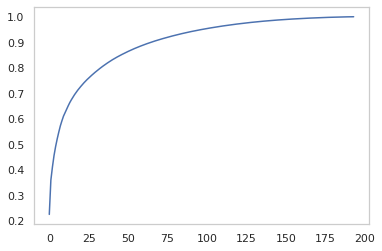

In [0]:
# standardization before pca
from sklearn.preprocessing import MinMaxScaler
annotated_empath_norm = pd.DataFrame(MinMaxScaler().fit_transform(annotated_df[feature_empath])) 
annotated_empath_norm.columns = annotated_df[feature_empath].columns

# generate a plot to identify the optimal number for component number
pca_empath = PCA(n_components=len(feature_empath))
pca_empath.fit_transform(annotated_empath_norm)
pc_vs_variance_empath = np.cumsum(pca_empath.explained_variance_ratio_)
plt.plot(pc_vs_variance_empath)
plt.grid(False)

As the plot indicates, 50 components can represent over 85% of the variance. Therefore, we will like to set the component number as 50.


In [0]:
# reduce the dimension concerning empathy to 50 through pca
annotated_empath_pca = pd.DataFrame(PCA(n_components=50).fit_transform(annotated_empath_norm))

# add the user label variable into the transfered dataframe
annotated_empath_pca['hate']=annotated_df['hate'].reset_index().hate

In [0]:
# Compare models and display final result
best_by_metrics_empath, classifier_comparison_empath = compare_classifiers(classifiers, metrics, annotated_empath_pca, list(range(50)), 'hate', labels=[1,0], noisy = 'quiet')
# compare_classifiers(classifiers, metrics, df, feature_set, target, folds, shuffle, noisy, labels)
for metrics_name, classifier in best_by_metrics_empath.items():
  print(f"Based on the {metrics_name} of {list(classifier.values())[0]:.2f}, best classifier is: {list(classifier.keys())[0]}.")    


Random Forest: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 91.938
-------------
Bagging Classifier: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 87.343
-------------
Ada Boost: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 86.420
-------------
Random Forest: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.445
-------------
Bagging Classifier: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.376
-------------
Ada Boost: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.343
-------------
Random Forest: Fold 0...1...2...3...4...5...6...7...8...9
Average F1 scores: 0.491
-------------
Bagging Classifier: Fold 0...1...2...3...4...5...6...7...8...9
Average F1 scores: 0.425
-------------
Ada Boost: Fold 0...1...2...3...4...5...6...7...8...9
Average F1 scores: 0.411
-------------
Based on the Accuracy of 91.94, best classifier is: Random Forest.
Based on the Kappa of 0.44, best classifier is: Random Forest.
Based 

In summary, targeting the numeric feature, the Random Forest classifer can work best for the prediction, which is generated through the grid search, `grid_rf_class`.

In [0]:
from sklearn.pipeline import Pipeline # combine the best estimator with pca
best_model_empath = grid_rf_class.best_estimator_

pipeline_empath = Pipeline([('PCA', PCA(n_components=50)), ('Random Forest', best_model_empath)])
pipeline_empath

Pipeline(memory=None,
         steps=[('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=50,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('Random Forest',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=10, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
           

## 4.4. Glove Vector Analysis
Since there are 300 variables in the Glove Vector group, representing the text in each post. Dimension Reduction needs introducing firstly.

In [0]:
# Compare models and display final result
best_by_metrics_glove, classifier_comparison_glove = compare_classifiers(classifiers, metrics, 
                              annotated_df[feature_glove_hate], feature_glove,
                              'hate', labels=[1,0], noisy = 'quiet')
# compare_classifiers(classifiers, metrics, df, feature_set, target, folds, shuffle, noisy, labels)
for metrics_name, classifier in best_by_metrics_glove.items():
  print(f"Based on the {metrics_name} of {list(classifier.values())[0]:.2f}, best classifier is: {list(classifier.keys())[0]}.")    


Random Forest: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 92.226
-------------
Bagging Classifier: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 88.205
-------------
Ada Boost: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 87.548
-------------
Random Forest: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.517
-------------
Bagging Classifier: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.368
-------------
Ada Boost: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.391
-------------
Random Forest: Fold 0...1...2...3...4...5...6...7...8...9
Average F1 scores: 0.541
-------------
Bagging Classifier: Fold 0...1...2...3...4...5...6...7...8...9
Average F1 scores: 0.441
-------------
Ada Boost: Fold 0...1...2...3...4...5...6...7...8...9
Average F1 scores: 0.448
-------------
Based on the Accuracy of 92.23, best classifier is: Random Forest.
Based on the Kappa of 0.52, best classifier is: Random Forest.
Based 

In summary, targeting the numeric feature, the Random Forest classifer can work best for the prediction, which is generated through the grid search, `grid_rf_class`.

In [0]:
best_model_glove = grid_rf_class.best_estimator_
best_model_glove

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## 4.5. Summary for Prediction Model

The following table offers us a more clear insight into the variables.

| Feature Group |   Best Model  | Performance |
|-------|---------|---------|
| **Numeric Features**   |   Random Forest: `best_model_numeric`   | Accuracy: 91.180, Kappa: 0.384, F1: 0.405 |
| **Empathy Features (Post Topic)**  | Random Forest: `pipeline_empath`  | Accuracy: 91.938, Kappa: 0.445, F1: 0.491  |
| **Glove Vectors (Post Text)**  |  Random Forest: `best_model_glove`  | Accuracy: 92.226, Kappa: 0.517, F1: 0.541 |

These three models based on different features all show great performance. We can apply them in a coplimentary way to identify the hateful users.

# 5. Unannotated User Clustering

Without the information of the whole webpage context, I cannot annotate the users who haven’t been labeled as hateful or normal. However, among these unannotated instances, I can cluster them by the Kmeans algorithm. Through the comparison of the features over different centroids, I can identify certain features of each cluster. Since we have generated the common features among the hateful users, the cluster features can potentially serve as the reference for future hateful/normal user annotation, significantly improving the efficiency of the annotation work. Then, more academic research can be conducted based on more instances labeled, thus significantly promoting the development of the identification algorithm.
Without the specific information of the posts, here I will focus on the numeric features rather than the features of posts and topics. 

In [0]:
from sklearn.cluster import KMeans

# standardize the features
unannotated_numeric_norm = MinMaxScaler().fit_transform(unannotated_df[feature_numeric])

In [0]:
# use elbow method to identify the optimal cluster
sum_of_squared_distances = [] # generate a list to record the sum of squared distance
K = range(1,18)
for k in K:
  km = KMeans(n_clusters=k)
  km = km.fit(unannotated_numeric_norm)
  sum_of_squared_distances.append(km.inertia_)

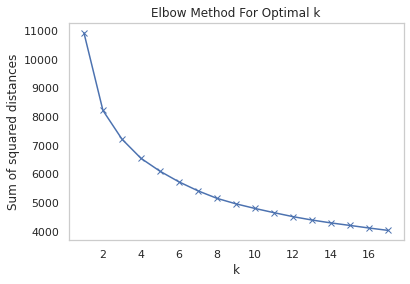

In [0]:
# visualize the "elbow"
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.grid(False)

As the plot indicates, I can take 6 as the cluster number.

In [0]:
km_optimal = KMeans(n_clusters=6).fit(unannotated_numeric_norm)
unannotated_df['cluster'] = km_optimal.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
# aggregate the instances by cluster to identify cluster fewatures
unannotated_df.groupby('cluster').mean()

c_statuses_count_log  ...  c_status length
cluster                        ...                 
0                    8.735528  ...       128.174707
1                    7.826777  ...       120.732431
2                    9.737814  ...       120.283812
3                   10.361834  ...        99.344289
4                   10.537846  ...        98.014864
5                    9.932943  ...        89.948022

[6 rows x 517 columns]

As the table indicates, we can identify the variance in status number, follower number, favourite tweet number, etc. by clusters.

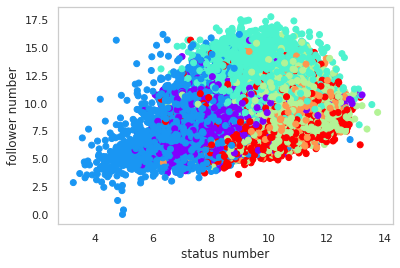

In [0]:
# visulize cluster feature by scatter plot
plt.scatter(unannotated_df["c_statuses_count_log"], unannotated_df["c_followers_count_log"], c=unannotated_df["cluster"], cmap="rainbow")
plt.xlabel('status number')
plt.ylabel('follower number')
plt.grid(False)

As this scatter plot indicates, the users with less status are likely to have less followers.

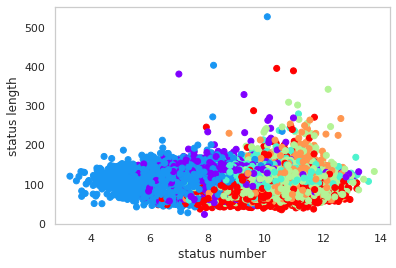

In [0]:
# visulize cluster feature by scatter plot
plt.scatter(unannotated_df["c_statuses_count_log"], unannotated_df["c_status length"], c=unannotated_df["cluster"], cmap="rainbow")
plt.xlabel('status number')
plt.ylabel('status length')
plt.grid(False)

Also, for the users who have less status, their posts are likely to be shorter.

There can be more interesting stories behind these six clusters. We won't dive into them for now. I hope that the further cluster analysis work can lead to promote more researh on the hateful user identification.